In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
import psycopg2
from pandas.io.json import json_normalize
from classify_campaigns import classify_campaigns

import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import dataframe_image as dfi

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [2]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')

In [3]:
start_dt = '2021-09-10'
end_dt = '2021-10-10'

(1) Is the system capping correctly for all Ad Formats/Ad Sizes based on defaults?

(2) What should be the default frequency caps be based on conversion drop-offs?

bids auctions - post 8/13.

In [67]:
query = """
select
    r.tid
    , r.id
    , r.date
    , extract(hour from r.timestamp) as hour
    , r.timestamp
    , r.etimestamp
    , r.exchange_id
    , sp.bundle as sponsored_bnd
    , ho.bundle as hosting_bnd
    , ho.name as hosting_app_name
    , r.ssb_campaign_uuid
    , c.name as campaign_name
    , r.exploration_uuid
    , r.ad_type
    , r.ad_size
    , r.imp_type
    , r.country
    , r.ssb_buyer_id
    , r.campaign_lifetime_views
    , count(case when event_type = 'clear' then 1 else NULL end) as impressions
    , count(case when event_type = 'click' then 1 else NULL end) as clicks
    , count(case when event_type = 'install' then 1 else NULL end) as installs
    , sum(revenue) as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)/1000 as cost
    , dense_rank() over (partition by r.tid, r.ssb_campaign_uuid order by r.date) day_number_total
    , dense_rank() over (partition by r.tid, r.ad_type, r.ssb_campaign_uuid order by r.date) day_number_size
    , dense_rank() over (partition by r.tid, r.imp_type, r.ssb_campaign_uuid order by r.date) day_number_type
    , dense_rank() over (partition by r.tid, r.ssb_campaign_uuid order by r.date) day_number_size_adtype
    , dense_rank() over (partition by r.tid, r.date, r.ssb_campaign_uuid order by timestamp) imp_number_total_day
    , dense_rank() over (partition by r.tid, r.date, r.ad_type, r.ssb_campaign_uuid order by timestamp) imp_number_size_day
    , dense_rank() over (partition by r.tid, r.date, r.imp_type, r.ssb_campaign_uuid order by timestamp) imp_number_type_day
    , dense_rank() over (partition by r.tid, r.date, r.ssb_campaign_uuid order by timestamp) imp_number_size_adtype_day
    , dense_rank() over (partition by r.tid, r.date, extract(hour from r.timestamp), r.ssb_campaign_uuid order by timestamp) imp_number_total_hour
    , dense_rank() over (partition by r.tid, r.date, extract(hour from r.timestamp), r.ad_type, r.ssb_campaign_uuid order by timestamp) imp_number_size_hour
    , dense_rank() over (partition by r.tid, r.date, extract(hour from r.timestamp), r.imp_type, r.ssb_campaign_uuid order by timestamp) imp_number_type_hour
    , dense_rank() over (partition by r.tid, r.date, extract(hour from r.timestamp), r.ssb_campaign_uuid order by timestamp) imp_number_size_adtype_hour
    , dense_rank() over (partition by r.tid, r.ssb_campaign_uuid order by timestamp) imp_number_total_qtr
from stats.rows1 r
join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
left join metadata.apps ho
    on r.hosting_app_id = ho.app_id
join metadata.campaigns c
    on r.ssb_campaign_uuid = c.uuid
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and right(r.tid,2) = '{n}0'
    and r.ssb_buyer_id = 3549
    and event_type in ('clear','click','install')
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
"""

df_list = []
k = 1 # max of 10
for n in list(range(k)):
    print(f'Running query {n+1} of {k}')
    sub_df = bigquery_client.query(query.format(start_dt = start_dt, end_dt = end_dt, n = n)).to_dataframe()
    df_list.append(sub_df)

df = pd.concat(df_list)
del df_list
df = df.set_index('imp_type').join(imp_type.set_index('imp_type_id'), how = 'left').reset_index()
df = df.set_index('exchange_id').join(exchange.set_index('exchange_id'), how = 'left').reset_index()

Running query 1 of 1


In [68]:

format_map = {'imp_sov':'{:,.1f}%'
             ,'spend_sov':'{:,.1f}%'
             ,'rev_sov':'{:,.1f}%'
             ,'cost_sov':'{:,.1f}%'
             ,'ctr':'{:,.1f}%'
             ,'ir':'{:,.1f}%'
             ,'margin':'{:,.0f}%'
             ,'impressions':'{:,.0f}'
             ,'clicks':'{:,.0f}'
             ,'tid':'{:,.0f}'
             ,'installs':'{:,.0f}'
             ,'ipm':'{:,.2f}'
             ,'cpm':'${:,.2f}'
             ,'cost':'${:,.0f}'
             ,'spend':'${:,.0f}'
             ,'profit':'${:,.0f}'}

# caps by day

In [7]:
pivot = df.loc[(df.tid == '555862fb8a1e02023406e50580af9000') & (df.ssb_campaign_uuid == '88f5ef330c5d9e2a10cc0c035e8ee195')]
pivot[['tid','date','hour','ssb_campaign_uuid','impressions','imp_number_total_day']]

tid        date  hour  \
7631817   555862fb8a1e02023406e50580af9000  2021-08-03     2   
10757798  555862fb8a1e02023406e50580af9000  2021-07-11     2   
23588292  555862fb8a1e02023406e50580af9000  2021-08-16    14   
23735272  555862fb8a1e02023406e50580af9000  2021-08-21     3   
23912818  555862fb8a1e02023406e50580af9000  2021-07-25     2   
24237188  555862fb8a1e02023406e50580af9000  2021-07-24    23   
24341054  555862fb8a1e02023406e50580af9000  2021-08-16    21   
24533464  555862fb8a1e02023406e50580af9000  2021-08-08    20   
24578306  555862fb8a1e02023406e50580af9000  2021-08-07     3   
24666037  555862fb8a1e02023406e50580af9000  2021-07-21     6   
24666166  555862fb8a1e02023406e50580af9000  2021-07-26     3   
24710832  555862fb8a1e02023406e50580af9000  2021-08-20     5   
24799395  555862fb8a1e02023406e50580af9000  2021-07-23     3   

                         ssb_campaign_uuid  impressions  imp_number_total_day  
7631817   88f5ef330c5d9e2a10cc0c035e8ee195            1                     1  
10757798  88f5ef330c5d9e2a10cc0c035e8ee195            1                     1  
23588292  88f5ef330c5d9e2a10cc0c035e8ee195            1                     1  
23735272  88f5ef330c5d9e2a10cc0c035e8ee195            1                     1  
23912818  88f5ef330c5d9e2a10cc0c035e8ee195            1                     1  
24237188  88f5ef330c5d9e2a10cc0c035e8ee195            1                     1  
24341054  88f5ef330c5d9e2a10cc0c035e8ee195            1                     2  
24533464  88f5ef330c5d9e2a10cc0c035e8ee195            1                     1  
24578306  88f5ef330c5d9e2a10cc0c035e8ee195            1                     1  
24666037  88f5ef330c5d9e2a10cc0c035e8ee195            1                     1  
24666166  88f5ef330c5d9e2a10cc0c035e8ee195            1                     1  
24710832  88f5ef330c5d9e2a10cc0c035e8ee195            1                     1  
24799395  88f5ef330c5d9e2a10cc0c035e8ee195            1                     1

In [8]:
g = 'imp_number_total_day'
pivot = (256/k)*df.pivot_table(values = ['impressions','clicks','installs','spend','cost','tid'], index = g
                                     , aggfunc = {'impressions':np.sum, 'clicks':np.sum,'installs':np.sum
                                                 ,'spend':np.sum, 'cost':np.sum, 'tid':lambda x:len(x.unique())})
pivot['imp_sov'] = 100*pivot['impressions']/pivot['impressions'].sum()
pivot['spend_sov'] = 100*pivot['spend']/pivot['spend'].sum()
pivot['cost_sov'] = 100*pivot['cost']/pivot['cost'].sum()
pivot['profit'] = pivot['spend'] - pivot['cost']
pivot['margin'] = 100*np.where(pivot['spend']>0, pivot['profit']/pivot['spend'], np.nan)
pivot['ctr'] = 100*pivot['clicks']/pivot['impressions']
pivot['ir'] = 100*pivot['installs']/pivot['clicks']
pivot['ipm'] = 1000*pivot['installs']/pivot['impressions']

cols = ['tid','imp_sov','ctr','ir','ipm','installs','spend','spend_sov','cost','cost_sov','profit','margin']
format_pivot = pivot.loc[pivot.index <= 40, cols].style.format(format_map)
format_pivot = format_pivot.background_gradient(cmap = cm, subset = ['imp_sov','spend_sov','cost_sov','ctr','ir','ipm','margin'])
format_pivot = format_pivot.applymap(lambda x:'background-color:white; color:white' if np.isnan(x) else '')
format_pivot


Text(0.5, 1.0, 'IPM by impression # per day')

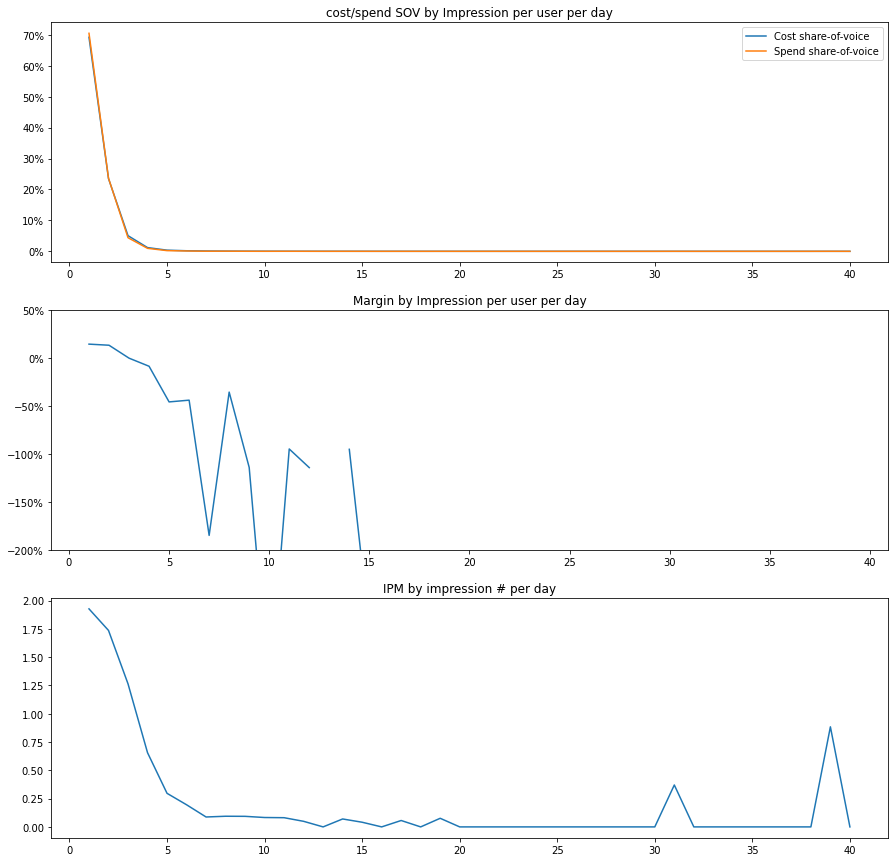

In [9]:
cols = ['imp_sov','ipm','margin']

fig, ax = plt.subplots(3,1,figsize = (15,15))
ax[0].plot(pivot.loc[:40, ['cost_sov','spend_sov']])
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[0].set_title('cost/spend SOV by Impression per user per day')
ax[0].legend(['Cost share-of-voice','Spend share-of-voice'])
ax[1].plot(pivot.loc[:40, 'margin'])
ax[1].set_title('Margin by Impression per user per day')
ax[1].set_ylim([-200,50])
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[2].plot(pivot.loc[:40, ['ipm']])
ax[2].set_title('IPM by impression # per day')

In [10]:
g = 'ad_type'
top_groupings = df.groupby(g)['spend'].sum().sort_values(ascending = False)[:8].index.tolist()

pivot = (256/k)*df[df[g].isin(top_groupings)].groupby([g,'imp_number_size_day'])['impressions','clicks','installs','spend','cost'].sum()
pivot['imp_sov'] = 100*pivot['impressions']/pivot['impressions'].groupby(g).transform('sum')
pivot['spend_sov'] = 100*pivot['spend']/pivot['spend'].groupby(g).transform('sum')
pivot['cost_sov'] = 100*pivot['cost']/pivot['cost'].groupby(g).transform('sum')
pivot['profit'] = pivot['spend'] - pivot['cost']
pivot['margin'] = 100*np.where(pivot['spend']>0, pivot['profit']/pivot['spend'], np.nan)
pivot['ctr'] = 100*pivot['clicks']/pivot['impressions']
pivot['ir'] = 100*pivot['installs']/pivot['clicks']
pivot['ipm'] = 1000*pivot['installs']/pivot['impressions']


cols = ['imp_sov','ctr','ir','ipm','installs','spend','spend_sov','cost','cost_sov','profit','margin']
format_pivot = pivot.loc[pivot.index.get_level_values(1) <= 15, cols].style.format(format_map)
format_pivot = format_pivot.background_gradient(cmap = cm, subset = ['imp_sov','spend_sov','cost_sov','ctr','ir','ipm','margin'])
format_pivot = format_pivot.applymap(lambda x:'background-color:white; color:white' if np.isnan(x) else '')
format_pivot


<ipython-input-10-8a74371a5521>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pivot = (256/k)*df[df[g].isin(top_groupings)].groupby([g,'imp_number_size_day'])['impressions','clicks','installs','spend','cost'].sum()


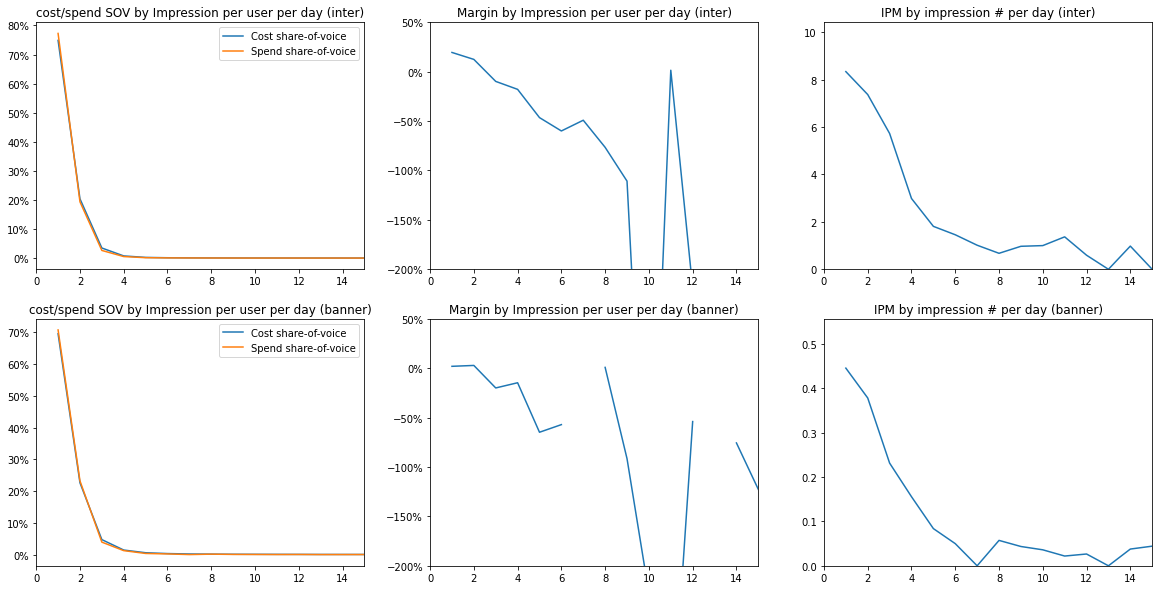

In [11]:
cols = ['imp_sov','ipm','margin']

fig, ax = plt.subplots(len(top_groupings),3,figsize = (20,5*len(top_groupings)))

for n in range(len(top_groupings)):
    grouping = top_groupings[n]
    sub_pivot = pivot[pivot.index.get_level_values(0) == grouping].droplevel(0, axis = 0)

    ax[n,0].plot(sub_pivot.loc[:, ['cost_sov','spend_sov']])
    ax[n,0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
    ax[n,0].set_title(f'cost/spend SOV by Impression per user per day ({grouping})')
    ax[n,0].legend(['Cost share-of-voice','Spend share-of-voice'])
    ax[n,0].set_xlim(0,15)
    ax[n,0].xaxis.set_ticks(np.arange(0,15,2))
    ax[n,1].plot(sub_pivot.loc[:, 'margin'])
    ax[n,1].set_title(f'Margin by Impression per user per day ({grouping})')
    ax[n,1].set_ylim([-200,50])
    ax[n,1].set_xlim(0,15)
    ax[n,1].xaxis.set_ticks(np.arange(0,15,2))
    ax[n,1].yaxis.set_major_formatter(mtick.PercentFormatter(100))
    ax[n,2].plot(sub_pivot.loc[:, ['ipm']])
    ax[n,2].set_title(f'IPM by impression # per day ({grouping})')
    ax[n,2].set_xlim(0,15)
    ax[n,2].xaxis.set_ticks(np.arange(0,15,2))
    ymax = sub_pivot.loc[1,'ipm']*1.25
    ax[n,2].set_ylim([0,ymax])

In [12]:
g = 'impression type'
top_groupings = df.groupby(g)['spend'].sum().sort_values(ascending = False)[:4].index.tolist()

pivot = (256/k)*df[df[g].isin(top_groupings)].groupby([g,'imp_number_type_day'])['impressions','clicks','installs','spend','cost'].sum()
pivot['imp_sov'] = 100*pivot['impressions']/pivot['impressions'].groupby(g).transform('sum')
pivot['spend_sov'] = 100*pivot['spend']/pivot['spend'].groupby(g).transform('sum')
pivot['cost_sov'] = 100*pivot['cost']/pivot['cost'].groupby(g).transform('sum')
pivot['profit'] = pivot['spend'] - pivot['cost']
pivot['margin'] = 100*np.where(pivot['spend']>0, pivot['profit']/pivot['spend'], np.nan)
pivot['ctr'] = 100*pivot['clicks']/pivot['impressions']
pivot['ir'] = 100*pivot['installs']/pivot['clicks']
pivot['ipm'] = 1000*pivot['installs']/pivot['impressions']


cols = ['imp_sov','ctr','ir','ipm','installs','spend','spend_sov','cost','cost_sov','profit','margin']
format_pivot = pivot.loc[pivot.index.get_level_values(1) <= 15, cols].style.format(format_map)
format_pivot = format_pivot.background_gradient(cmap = cm, subset = ['imp_sov','spend_sov','cost_sov','ctr','ir','ipm','margin'])
format_pivot = format_pivot.applymap(lambda x:'background-color:white; color:white' if np.isnan(x) else '')
format_pivot


<ipython-input-12-a078335c9d62>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pivot = (256/k)*df[df[g].isin(top_groupings)].groupby([g,'imp_number_type_day'])['impressions','clicks','installs','spend','cost'].sum()


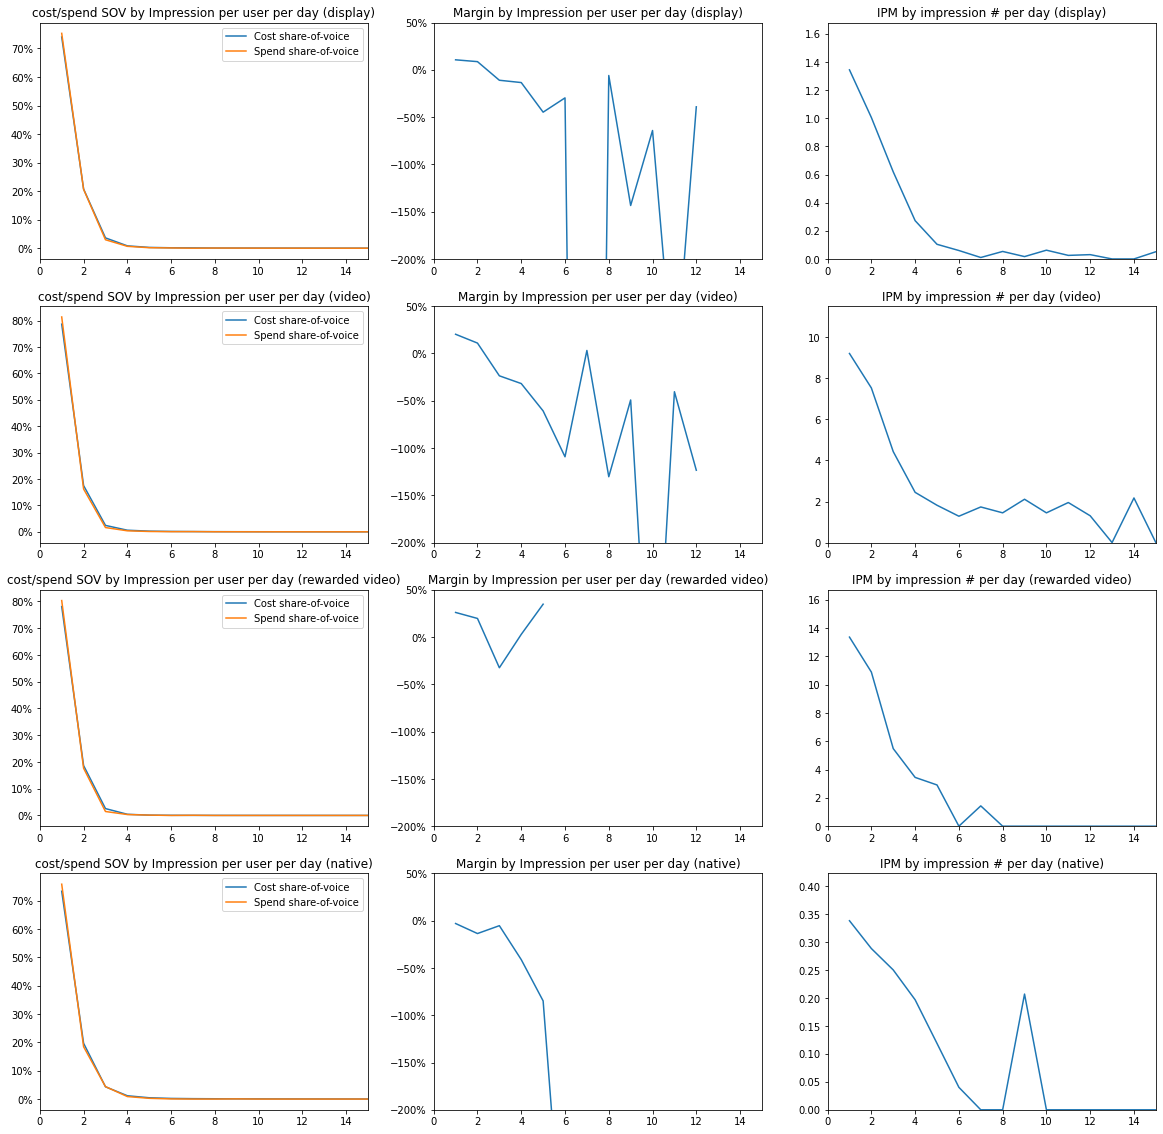

In [13]:
cols = ['imp_sov','ipm','margin']

fig, ax = plt.subplots(len(top_groupings),3,figsize = (20,5*len(top_groupings)))

for n in range(len(top_groupings)):
    grouping = top_groupings[n]
    sub_pivot = pivot[pivot.index.get_level_values(0) == grouping].droplevel(0, axis = 0)

    ax[n,0].plot(sub_pivot.loc[:, ['cost_sov','spend_sov']])
    ax[n,0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
    ax[n,0].set_title(f'cost/spend SOV by Impression per user per day ({grouping})')
    ax[n,0].legend(['Cost share-of-voice','Spend share-of-voice'])
    ax[n,0].set_xlim(0,15)
    ax[n,0].xaxis.set_ticks(np.arange(0,15,2))
    ax[n,1].plot(sub_pivot.loc[:, 'margin'])
    ax[n,1].set_title(f'Margin by Impression per user per day ({grouping})')
    ax[n,1].set_ylim([-200,50])
    ax[n,1].set_xlim(0,15)
    ax[n,1].xaxis.set_ticks(np.arange(0,15,2))
    ax[n,1].yaxis.set_major_formatter(mtick.PercentFormatter(100))
    ax[n,2].plot(sub_pivot.loc[:, ['ipm']])
    ax[n,2].set_title(f'IPM by impression # per day ({grouping})')
    ax[n,2].set_xlim(0,15)
    ax[n,2].xaxis.set_ticks(np.arange(0,15,2))
    ymax = sub_pivot.loc[1,'ipm']*1.25
    ax[n,2].set_ylim([0,ymax])

In [14]:
g = ['impression type', 'ad_type']
top_groupings_tuples = df.groupby(g)['spend'].sum().sort_values(ascending = False)[:5].index.tolist()
top_groupings = list(zip(*top_groupings_tuples))

filters = (df[g[0]].isin(top_groupings[0])) & (df[g[1]].isin(top_groupings[1]))

pivot = (256/k)*df[filters].groupby(g + ['imp_number_size_adtype_day'])['impressions','clicks','installs','spend','cost'].sum()
pivot['imp_sov'] = 100*pivot['impressions']/pivot['impressions'].groupby(g).transform('sum')
pivot['spend_sov'] = 100*pivot['spend']/pivot['spend'].groupby(g).transform('sum')
pivot['cost_sov'] = 100*pivot['cost']/pivot['cost'].groupby(g).transform('sum')
pivot['profit'] = pivot['spend'] - pivot['cost']
pivot['margin'] = 100*np.where(pivot['spend']>0, pivot['profit']/pivot['spend'], np.nan)
pivot['ctr'] = 100*pivot['clicks']/pivot['impressions']
pivot['ir'] = 100*pivot['installs']/pivot['clicks']
pivot['ipm'] = 1000*pivot['installs']/pivot['impressions']

cols = ['impressions','imp_sov','ctr','ir','ipm','installs','spend','spend_sov','cost','cost_sov','profit','margin']
format_pivot = pivot.loc[pivot.index.get_level_values(len(g)) <= 15, cols].style.format(format_map)
format_pivot = format_pivot.background_gradient(cmap = cm, subset = ['imp_sov','spend_sov','cost_sov','ctr','ir','ipm','margin'])
format_pivot = format_pivot.applymap(lambda x:'background-color:white; color:white' if np.isnan(x) else '')
format_pivot


<ipython-input-14-2b92ce9a2727>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pivot = (256/k)*df[filters].groupby(g + ['imp_number_size_adtype_day'])['impressions','clicks','installs','spend','cost'].sum()


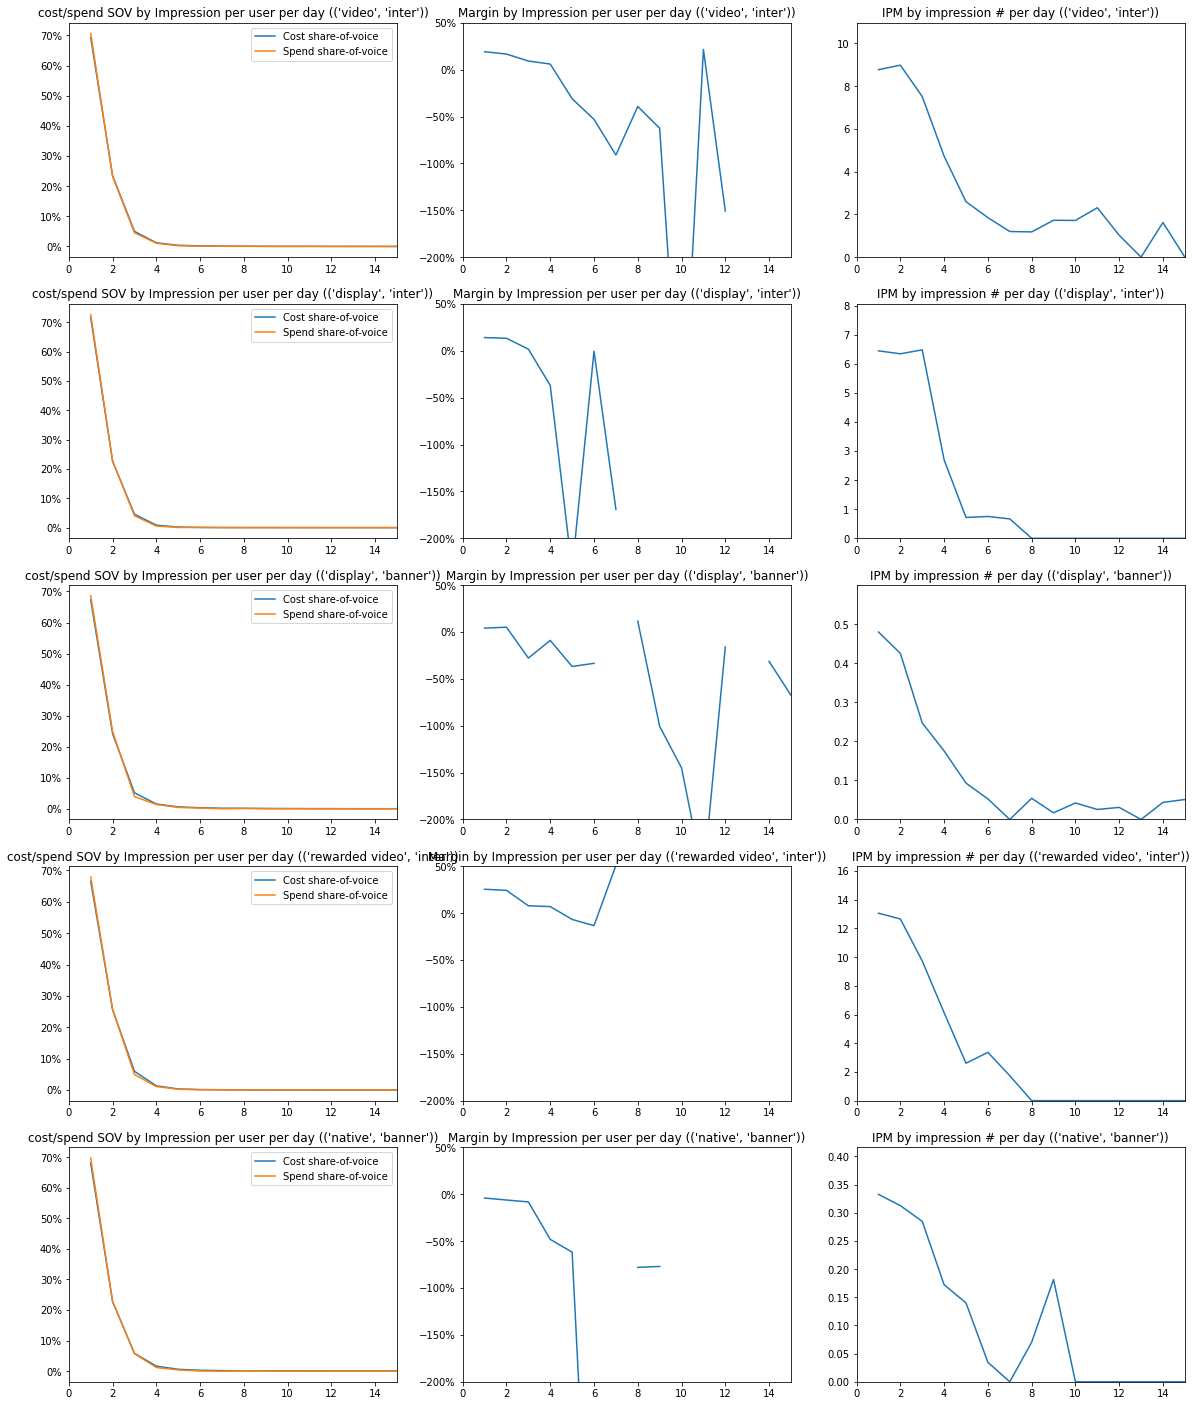

In [15]:
cols = ['imp_sov','ipm','margin']

fig, ax = plt.subplots(len(top_groupings[0]),3,figsize = (20,5*len(top_groupings[0])))

for n in range(len(top_groupings[0])):
    grouping = top_groupings_tuples[n]
    filters = (pivot.index.get_level_values(0) == grouping[0]) & (pivot.index.get_level_values(1) == grouping[1])
    sub_pivot = pivot[filters].droplevel([0,1], axis = 0)

    ax[n,0].plot(sub_pivot[['cost_sov','spend_sov']])
    ax[n,0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
    ax[n,0].set_title(f'cost/spend SOV by Impression per user per day ({grouping})')
    ax[n,0].legend(['Cost share-of-voice','Spend share-of-voice'])
    ax[n,0].set_xlim(0,15)
    ax[n,0].xaxis.set_ticks(np.arange(0,15,2))
    ax[n,1].plot(sub_pivot['margin'])
    ax[n,1].set_title(f'Margin by Impression per user per day ({grouping})')
    ax[n,1].set_ylim([-200,50])
    ax[n,1].set_xlim(0,15)
    ax[n,1].xaxis.set_ticks(np.arange(0,15,2))
    ax[n,1].yaxis.set_major_formatter(mtick.PercentFormatter(100))
    ax[n,2].plot(sub_pivot[['ipm']])
    ax[n,2].set_title(f'IPM by impression # per day ({grouping})')
    ax[n,2].set_xlim(0,15)
    ax[n,2].xaxis.set_ticks(np.arange(0,15,2))
    ymax = sub_pivot.loc[1,'ipm']*1.25
    ax[n,2].set_ylim([0,ymax])

## caps by hour

In [16]:
g = 'imp_number_total_hour'
pivot = (256/k)*df.groupby([g])['impressions','clicks','installs','spend','cost'].sum()
pivot['imp_sov'] = 100*pivot['impressions']/pivot['impressions'].sum()
pivot['spend_sov'] = 100*pivot['spend']/pivot['spend'].sum()
pivot['cost_sov'] = 100*pivot['cost']/pivot['cost'].sum()
pivot['profit'] = pivot['spend'] - pivot['cost']
pivot['margin'] = 100*np.where(pivot['spend']>0, pivot['profit']/pivot['spend'], np.nan)
pivot['ctr'] = 100*pivot['clicks']/pivot['impressions']
pivot['ir'] = 100*pivot['installs']/pivot['clicks']
pivot['ipm'] = 1000*pivot['installs']/pivot['impressions']

cols = ['imp_sov','ctr','ir','ipm','installs','spend','spend_sov','cost','cost_sov','profit','margin']
format_pivot = pivot.loc[pivot.index <= 15, cols].style.format(format_map)
format_pivot = format_pivot.background_gradient(cmap = cm, subset = ['imp_sov','spend_sov','cost_sov','ctr','ir','ipm','margin'])
format_pivot = format_pivot.applymap(lambda x:'background-color:white; color:white' if np.isnan(x) else '')
format_pivot


<ipython-input-16-97043526c56c>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pivot = (256/k)*df.groupby([g])['impressions','clicks','installs','spend','cost'].sum()


(0.0, 15.0)

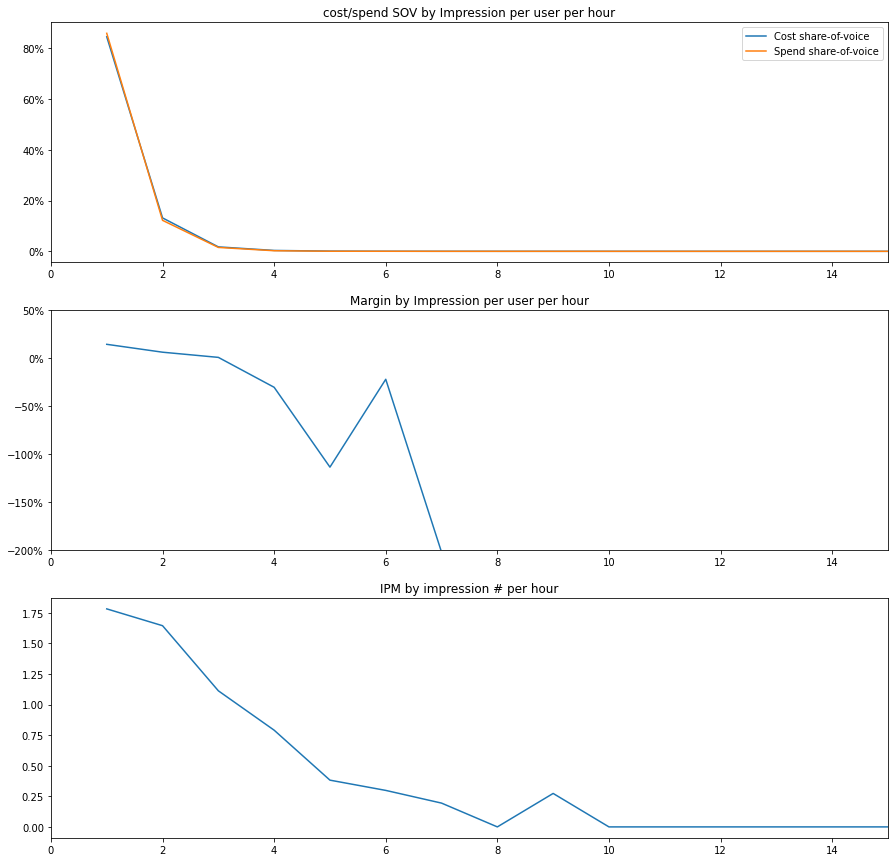

In [17]:
cols = ['imp_sov','ipm','margin']

fig, ax = plt.subplots(3,1,figsize = (15,15))
ax[0].plot(pivot.loc[:, ['cost_sov','spend_sov']])
ax[0].set_xlim([0,15])
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[0].set_title('cost/spend SOV by Impression per user per hour')
ax[0].legend(['Cost share-of-voice','Spend share-of-voice'])
ax[1].plot(pivot.loc[:, 'margin'])
ax[1].set_title('Margin by Impression per user per hour')
ax[1].set_ylim([-200,50])
ax[1].set_xlim([0,15])
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[2].plot(pivot.loc[:, ['ipm']])
ax[2].set_title('IPM by impression # per hour')
ax[2].set_xlim([0,15])

In [18]:
g = 'ad_type'
top_groupings = df.groupby(g)['spend'].sum().sort_values(ascending = False)[:7].index.tolist()

pivot = (256/k)*df[df[g].isin(top_groupings)].groupby([g,'imp_number_size_hour'])['impressions','clicks','installs','spend','cost'].sum()
pivot['imp_sov'] = 100*pivot['impressions']/pivot['impressions'].groupby(g).transform('sum')
pivot['spend_sov'] = 100*pivot['spend']/pivot['spend'].groupby(g).transform('sum')
pivot['cost_sov'] = 100*pivot['cost']/pivot['cost'].groupby(g).transform('sum')
pivot['profit'] = pivot['spend'] - pivot['cost']
pivot['margin'] = 100*np.where(pivot['spend']>0, pivot['profit']/pivot['spend'], np.nan)
pivot['ctr'] = 100*pivot['clicks']/pivot['impressions']
pivot['ir'] = 100*pivot['installs']/pivot['clicks']
pivot['ipm'] = 1000*pivot['installs']/pivot['impressions']

cols = ['imp_sov','ctr','ir','ipm','installs','spend','spend_sov','cost','cost_sov','profit','margin']
format_pivot = pivot.loc[pivot.index.get_level_values(1) <= 10, cols].style.format(format_map)
format_pivot = format_pivot.background_gradient(cmap = cm, subset = ['imp_sov','spend_sov','cost_sov','ctr','ir','ipm','margin'])
format_pivot = format_pivot.applymap(lambda x:'background-color:white; color:white' if np.isnan(x) else '')
format_pivot


<ipython-input-18-6c1b9e89cad1>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pivot = (256/k)*df[df[g].isin(top_groupings)].groupby([g,'imp_number_size_hour'])['impressions','clicks','installs','spend','cost'].sum()


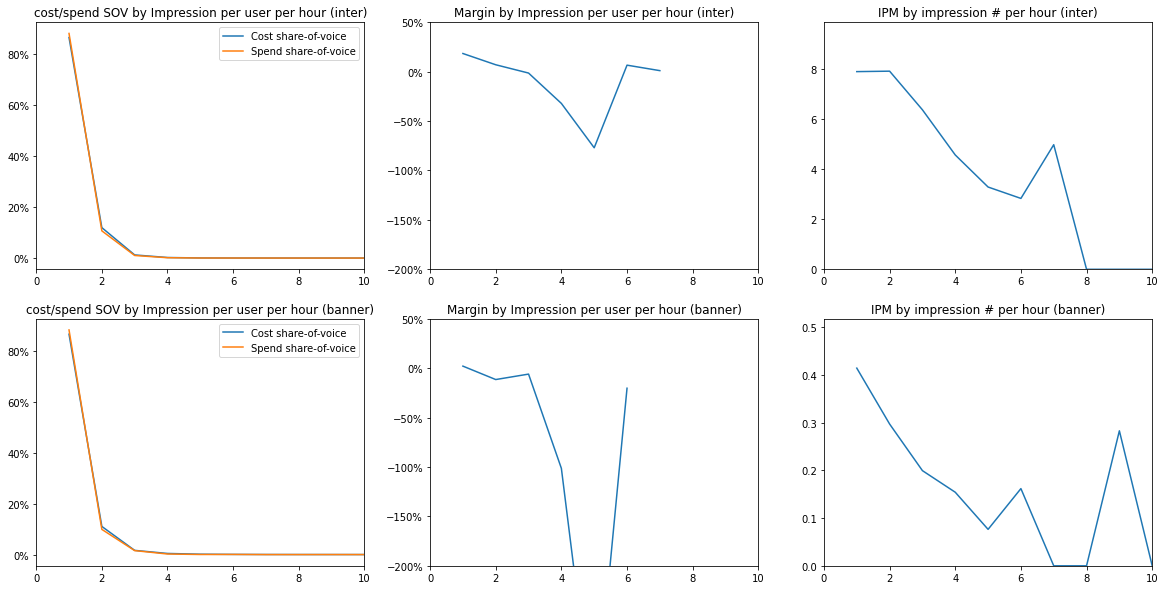

In [19]:
cols = ['imp_sov','ipm','margin']

fig, ax = plt.subplots(len(top_groupings),3,figsize = (20,5*len(top_groupings)))

for n in range(len(top_groupings)):
    grouping = top_groupings[n]
    sub_pivot = pivot[pivot.index.get_level_values(0) == grouping].droplevel(0, axis = 0)

    ax[n,0].plot(sub_pivot[['cost_sov','spend_sov']])
    ax[n,0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
    ax[n,0].set_title(f'cost/spend SOV by Impression per user per hour ({grouping})')
    ax[n,0].legend(['Cost share-of-voice','Spend share-of-voice'])
    ax[n,0].set_xlim([0,10])
    ax[n,1].plot(sub_pivot['margin'])
    ax[n,1].set_title(f'Margin by Impression per user per hour ({grouping})')
    ax[n,1].set_ylim([-200,50])
    ax[n,1].set_xlim([0,10])
    ax[n,1].yaxis.set_major_formatter(mtick.PercentFormatter(100))
    ax[n,2].plot(sub_pivot[['ipm']])
    ax[n,2].set_title(f'IPM by impression # per hour ({grouping})')
    ax[n,2].set_xlim([0,10])
    ymax = sub_pivot.loc[1,'ipm']*1.25
    ax[n,2].set_ylim([0,ymax])

In [20]:
g = 'impression type'
top_groupings = df.groupby(g)['spend'].sum().sort_values(ascending = False)[:4].index.tolist()

pivot = (256/k)*df[df[g].isin(top_groupings)].groupby([g,'imp_number_type_hour'])['impressions','clicks','installs','spend','cost'].sum()
pivot['imp_sov'] = 100*pivot['impressions']/pivot['impressions'].groupby(g).transform('sum')
pivot['spend_sov'] = 100*pivot['spend']/pivot['spend'].groupby(g).transform('sum')
pivot['cost_sov'] = 100*pivot['cost']/pivot['cost'].groupby(g).transform('sum')
pivot['profit'] = pivot['spend'] - pivot['cost']
pivot['margin'] = 100*np.where(pivot['spend']>0, pivot['profit']/pivot['spend'], np.nan)
pivot['ctr'] = 100*pivot['clicks']/pivot['impressions']
pivot['ir'] = 100*pivot['installs']/pivot['clicks']
pivot['ipm'] = 1000*pivot['installs']/pivot['impressions']


cols = ['imp_sov','ctr','ir','ipm','installs','spend','spend_sov','cost','cost_sov','profit','margin']
format_pivot = pivot.loc[pivot.index.get_level_values(1) <= 15, cols].style.format(format_map)
format_pivot = format_pivot.background_gradient(cmap = cm, subset = ['imp_sov','spend_sov','cost_sov','ctr','ir','ipm','margin'])
format_pivot = format_pivot.applymap(lambda x:'background-color:white; color:white' if np.isnan(x) else '')
format_pivot


<ipython-input-20-909e88c7f8f9>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pivot = (256/k)*df[df[g].isin(top_groupings)].groupby([g,'imp_number_type_hour'])['impressions','clicks','installs','spend','cost'].sum()


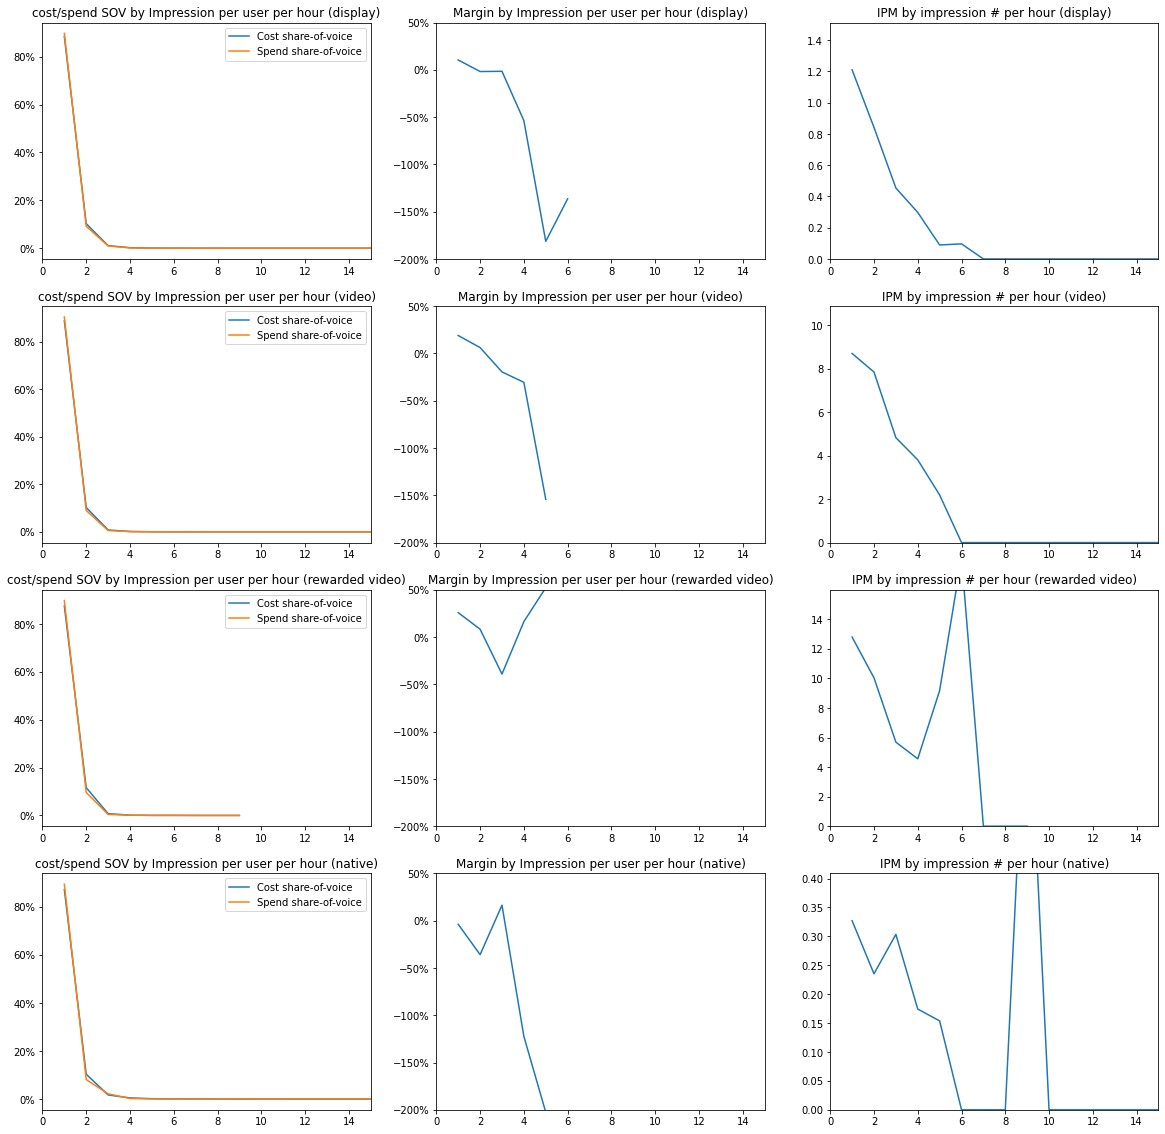

In [21]:
cols = ['imp_sov','ipm','margin']

fig, ax = plt.subplots(len(top_groupings),3,figsize = (20,5*len(top_groupings)))

for n in range(len(top_groupings)):
    grouping = top_groupings[n]
    sub_pivot = pivot[pivot.index.get_level_values(0) == grouping].droplevel(0, axis = 0)

    ax[n,0].plot(sub_pivot[['cost_sov','spend_sov']])
    ax[n,0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
    ax[n,0].set_title(f'cost/spend SOV by Impression per user per hour ({grouping})')
    ax[n,0].legend(['Cost share-of-voice','Spend share-of-voice'])
    ax[n,0].set_xlim([0,15])
    ax[n,1].plot(sub_pivot[['margin']])
    ax[n,1].set_title(f'Margin by Impression per user per hour ({grouping})')
    ax[n,1].set_ylim([-200,50])
    ax[n,1].set_xlim([0,15])
    ax[n,1].yaxis.set_major_formatter(mtick.PercentFormatter(100))
    ax[n,2].plot(sub_pivot[['ipm']])
    ax[n,2].set_title(f'IPM by impression # per hour ({grouping})')
    ax[n,2].set_xlim([0,15])
    ymax = sub_pivot.loc[1,'ipm']*1.25
    ax[n,2].set_ylim([0,ymax])

In [22]:
g = ['impression type', 'ad_type']
top_groupings_tuples = df.groupby(g)['spend'].sum().sort_values(ascending = False)[:5].index.tolist()
top_groupings = list(zip(*top_groupings_tuples))

filters = (df[g[0]].isin(top_groupings[0])) & (df[g[1]].isin(top_groupings[1]))

pivot = (256/k)*df[filters].groupby(g + ['imp_number_size_adtype_hour'])['impressions','clicks','installs','spend','cost'].sum()
pivot['imp_sov'] = 100*pivot['impressions']/pivot['impressions'].groupby(g).transform('sum')
pivot['spend_sov'] = 100*pivot['spend']/pivot['spend'].groupby(g).transform('sum')
pivot['cost_sov'] = 100*pivot['cost']/pivot['cost'].groupby(g).transform('sum')
pivot['profit'] = pivot['spend'] - pivot['cost']
pivot['margin'] = 100*np.where(pivot['spend']>0, pivot['profit']/pivot['spend'], np.nan)
pivot['ctr'] = 100*pivot['clicks']/pivot['impressions']
pivot['ir'] = 100*pivot['installs']/pivot['clicks']
pivot['ipm'] = 1000*pivot['installs']/pivot['impressions']

cols = ['imp_sov','ctr','ir','ipm','installs','spend','spend_sov','cost','cost_sov','profit','margin']
format_pivot = pivot.loc[pivot.index.get_level_values(len(g)) <= 10, cols].style.format(format_map)
format_pivot = format_pivot.background_gradient(cmap = cm, subset = ['imp_sov','spend_sov','cost_sov','ctr','ir','ipm','margin'])
format_pivot = format_pivot.applymap(lambda x:'background-color:white; color:white' if np.isnan(x) else '')
format_pivot


<ipython-input-22-d1074e1078b7>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pivot = (256/k)*df[filters].groupby(g + ['imp_number_size_adtype_hour'])['impressions','clicks','installs','spend','cost'].sum()


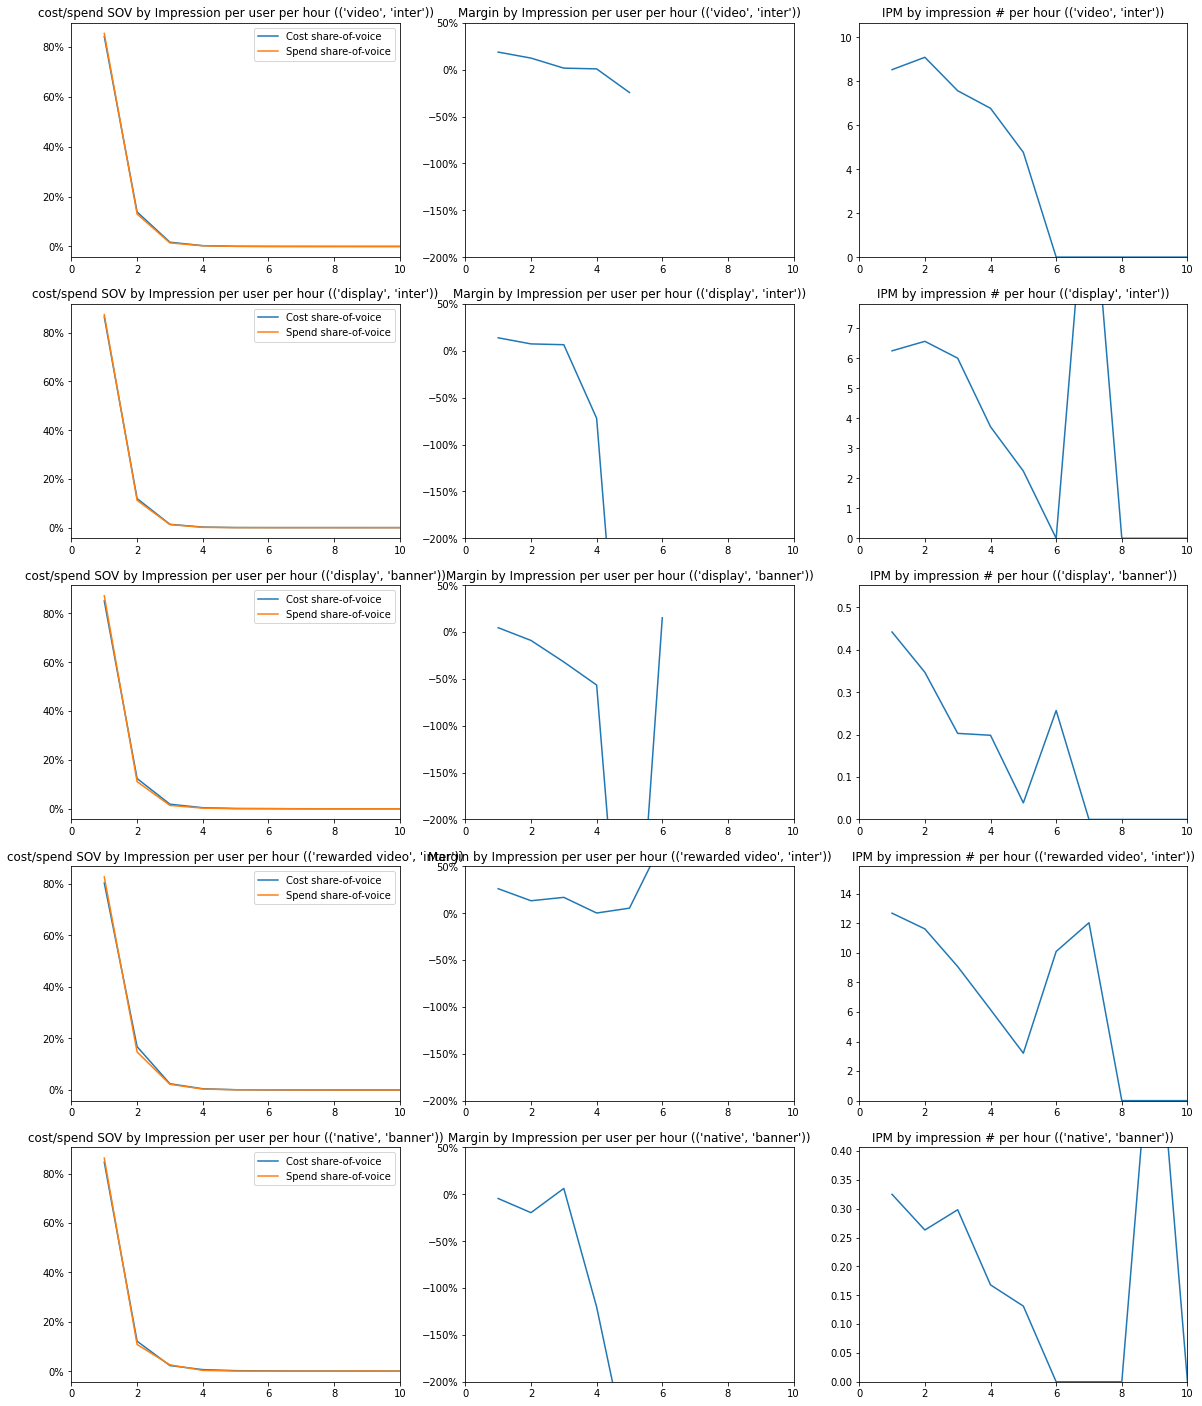

In [23]:
cols = ['imp_sov','ipm','margin']

fig, ax = plt.subplots(len(top_groupings[0]),3,figsize = (20,5*len(top_groupings[0])))

for n in range(len(top_groupings[0])):
    grouping = top_groupings_tuples[n]
    filters = (pivot.index.get_level_values(0) == grouping[0]) & (pivot.index.get_level_values(1) == grouping[1])
    sub_pivot = pivot[filters].droplevel([0,1], axis = 0)

    ax[n,0].plot(sub_pivot[['cost_sov','spend_sov']])
    ax[n,0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
    ax[n,0].set_title(f'cost/spend SOV by Impression per user per hour ({grouping})')
    ax[n,0].legend(['Cost share-of-voice','Spend share-of-voice'])
    ax[n,0].set_xlim([0,10])
    ax[n,1].plot(sub_pivot['margin'])
    ax[n,1].set_title(f'Margin by Impression per user per hour ({grouping})')
    ax[n,1].set_ylim([-200,50])
    ax[n,1].set_xlim([0,10])
    ax[n,1].yaxis.set_major_formatter(mtick.PercentFormatter(100))
    ax[n,2].plot(sub_pivot[['ipm']])
    ax[n,2].set_title(f'IPM by impression # per hour ({grouping})')
    ax[n,2].set_xlim([0,10])
    ymax = sub_pivot.loc[1,'ipm']*1.25
    ax[n,2].set_ylim([0,ymax])

# lifetime (quarterly) cap

In [24]:
df['imp_number_total_qtr'] = df.groupby(['tid','ssb_campaign_uuid'])['timestamp'].transform('rank', method = 'dense')

g = 'imp_number_total_qtr'
pivot = (256/k)*df.groupby([g])['impressions','clicks','installs','spend','cost'].sum()
pivot['imp_sov'] = 100*pivot['impressions']/pivot['impressions'].sum()
pivot['spend_sov'] = 100*pivot['spend']/pivot['spend'].sum()
pivot['cost_sov'] = 100*pivot['cost']/pivot['cost'].sum()
pivot['cum_cost_sov'] = 100*pivot['cost'].cumsum()/pivot['cost'].sum()
pivot['profit'] = pivot['spend'] - pivot['cost']
pivot['margin'] = 100*np.where(pivot['spend']>0, pivot['profit']/pivot['spend'], np.nan)
pivot['ctr'] = 100*pivot['clicks']/pivot['impressions']
pivot['ir'] = 100*pivot['installs']/pivot['clicks']
pivot['ipm'] = 1000*pivot['installs']/pivot['impressions']


cols = ['imp_sov','ctr','ir','ipm','installs','spend','spend_sov','cost','cost_sov','cum_cost_sov','profit','margin']
format_pivot = pivot.loc[pivot.index <= 50, cols].style.format(format_map)
format_pivot = format_pivot.background_gradient(cmap = cm, subset = ['imp_sov','spend_sov','cost_sov','cum_cost_sov','ctr','ir','ipm','margin'])
format_pivot = format_pivot.applymap(lambda x:'background-color:white; color:white' if np.isnan(x) else '')
format_pivot


<ipython-input-24-843ebde47818>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pivot = (256/k)*df.groupby([g])['impressions','clicks','installs','spend','cost'].sum()


(0.0, 2.309096003549034)

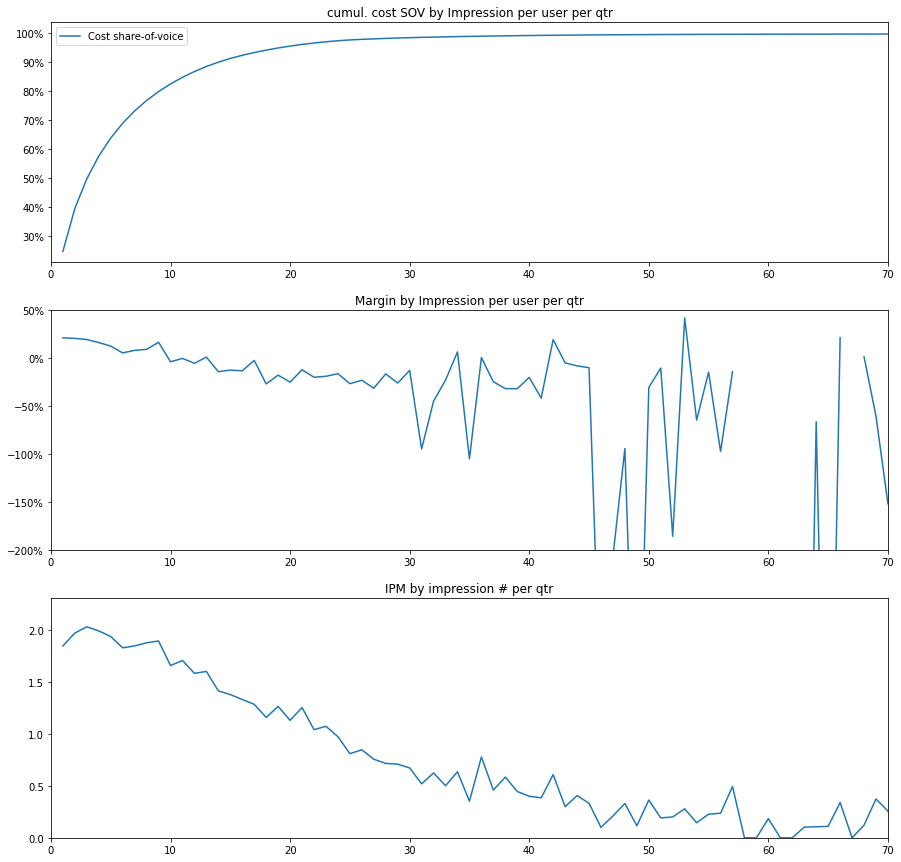

In [25]:
cols = ['imp_sov','ipm','margin']

fig, ax = plt.subplots(3,1,figsize = (15,15))
ax[0].plot(pivot.loc[:, ['cum_cost_sov']])
ax[0].set_xlim([0,70])
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[0].set_title('cumul. cost SOV by Impression per user per qtr')
ax[0].legend(['Cost share-of-voice','Spend share-of-voice'])
ax[1].plot(pivot.loc[:, 'margin'])
ax[1].set_title('Margin by Impression per user per qtr')
ax[1].set_ylim([-200,50])
ax[1].set_xlim([0,70])
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[2].plot(pivot.loc[:, ['ipm']])
ax[2].set_title('IPM by impression # per qtr')
ax[2].set_xlim([0,70])
ymax = pivot.loc[1,'ipm']*1.25
ax[2].set_ylim([0,ymax])

# Looking at campaign lifetime views

In [26]:
df.columns

Index(['exchange_id', 'index', 'tid', 'id', 'date', 'hour', 'timestamp',
       'etimestamp', 'sponsored_bnd', 'hosting_bnd', 'hosting_app_name',
       'ssb_campaign_uuid', 'campaign_name', 'exploration_uuid', 'ad_type',
       'ad_size', 'country', 'ssb_buyer_id', 'campaign_lifetime_views',
       'impressions', 'clicks', 'installs', 'spend', 'cost',
       'day_number_total', 'day_number_size', 'day_number_type',
       'day_number_size_adtype', 'imp_number_total_day', 'imp_number_size_day',
       'imp_number_type_day', 'imp_number_size_adtype_day',
       'imp_number_total_hour', 'imp_number_size_hour', 'imp_number_type_hour',
       'imp_number_size_adtype_hour', 'imp_number_total_qtr',
       'impression type', 'exchange_name'],
      dtype='object')

In [27]:
g = 'campaign_lifetime_views'
pivot = (256/k)*df.pivot_table(values = ['impressions','clicks','installs','spend','cost','tid'], index = g
                                     , aggfunc = {'impressions':np.sum, 'clicks':np.sum,'installs':np.sum
                                                 ,'spend':np.sum, 'cost':np.sum, 'tid':lambda x:len(x.unique())})
pivot['imp_sov'] = 100*pivot['impressions']/pivot['impressions'].sum()
pivot['spend_sov'] = 100*pivot['spend']/pivot['spend'].sum()
pivot['cost_sov'] = 100*pivot['cost']/pivot['cost'].sum()
pivot['cum_cost_sov'] = 100*pivot['cost'].cumsum()/pivot['cost'].sum()
pivot['profit'] = pivot['spend'] - pivot['cost']
pivot['margin'] = 100*np.where(pivot['spend']>0, pivot['profit']/pivot['spend'], np.nan)
pivot['ctr'] = 100*pivot['clicks']/pivot['impressions']
pivot['ir'] = 100*pivot['installs']/pivot['clicks']
pivot['ipm'] = 1000*pivot['installs']/pivot['impressions']

cols = ['tid','imp_sov','ctr','ir','ipm','installs','spend','spend_sov','cost','cost_sov','cum_cost_sov','profit','margin']
format_pivot = pivot.loc[pivot.index <= 40, cols].style.format(format_map)
format_pivot = format_pivot.background_gradient(cmap = cm, subset = ['imp_sov','spend_sov','cost_sov','cum_cost_sov','ctr','ir','ipm','margin'])
format_pivot = format_pivot.applymap(lambda x:'background-color:white; color:white' if np.isnan(x) else '')
format_pivot


(0.0, 3.2436977395826347)

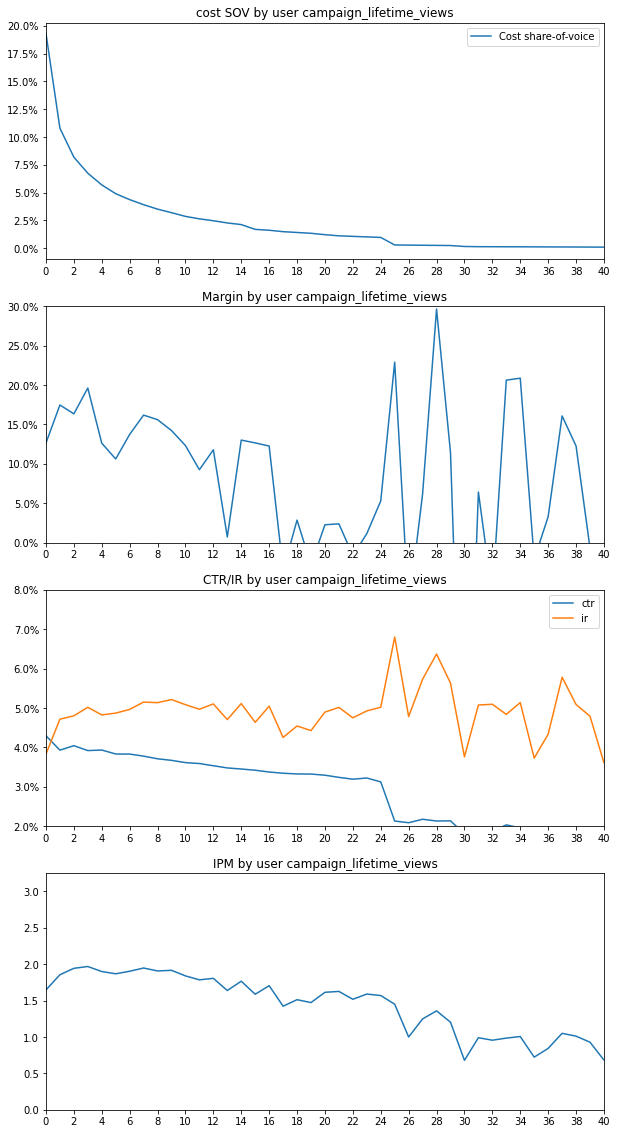

In [28]:
cols = ['imp_sov','ipm','margin']

fig, ax = plt.subplots(4,1,figsize = (10,20))
ax[0].plot(pivot.loc[:, ['cost_sov']])
ax[0].set_xlim([0,40])
ax[0].set_xticks(range(0,42,2))
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[0].set_title('cost SOV by user campaign_lifetime_views')
ax[0].legend(['Cost share-of-voice','Spend share-of-voice'])
ax[1].plot(pivot.loc[:, 'margin'])
ax[1].set_title('Margin by user campaign_lifetime_views')
ax[1].set_ylim([0,30])
ax[1].set_xlim([0,40])
ax[1].set_xticks(range(0,42,2))
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[2].plot(pivot.loc[:, ['ctr','ir']])
ax[2].legend(['ctr','ir'])
ax[2].set_title('CTR/IR by user campaign_lifetime_views')
ax[2].set_xlim([0,40])
ax[2].set_ylim([2,8])
ax[2].set_xticks(range(0,42,2))
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[3].plot(pivot.loc[:, ['ipm']])
ax[3].set_title('IPM by user campaign_lifetime_views')
ax[3].set_xlim([0,40])
ax[3].set_xticks(range(0,42,2))
ymax = pivot.loc[1,'ipm']*1.75
ax[3].set_ylim([0,ymax])

In [29]:
df.loc[(df.tid == '555862fb8a1e02023406e50580af9000') & (df.ssb_campaign_uuid == '88f5ef330c5d9e2a10cc0c035e8ee195')].sort_values('timestamp')

exchange_id  index                               tid  \
10757798            3    1.0  555862fb8a1e02023406e50580af9000   
24666037           44    1.0  555862fb8a1e02023406e50580af9000   
24799395           44    1.0  555862fb8a1e02023406e50580af9000   
24237188           44    1.0  555862fb8a1e02023406e50580af9000   
23912818           44    1.0  555862fb8a1e02023406e50580af9000   
24666166           44    1.0  555862fb8a1e02023406e50580af9000   
7631817             3    1.0  555862fb8a1e02023406e50580af9000   
24578306           44    1.0  555862fb8a1e02023406e50580af9000   
24533464           44    1.0  555862fb8a1e02023406e50580af9000   
23588292           44    1.0  555862fb8a1e02023406e50580af9000   
24341054           44    1.0  555862fb8a1e02023406e50580af9000   
24710832           44    1.0  555862fb8a1e02023406e50580af9000   
23735272           44    1.0  555862fb8a1e02023406e50580af9000   

                                                         id        date  hour  \
10757798  555862fb8a1e02023406e50580af900078b79257867dfb...  2021-07-11     2   
24666037  555862fb8a1e02023406e50580af9000611fce3c2a1ebb...  2021-07-21     6   
24799395  555862fb8a1e02023406e50580af90007404f53c08be22...  2021-07-23     3   
24237188  555862fb8a1e02023406e50580af9000577a544662656b...  2021-07-24    23   
23912818  555862fb8a1e02023406e50580af90007d94b0b2106540...  2021-07-25     2   
24666166  555862fb8a1e02023406e50580af90005084a17cddca83...  2021-07-26     3   
7631817   555862fb8a1e02023406e50580af90004d1b71d6168ed3...  2021-08-03     2   
24578306  555862fb8a1e02023406e50580af9000762b07074c9eb4...  2021-08-07     3   
24533464  555862fb8a1e02023406e50580af900040f78cb95a6101...  2021-08-08    20   
23588292  555862fb8a1e02023406e50580af90007a779a50596b88...  2021-08-16    14   
24341054  555862fb8a1e02023406e50580af900073af33016c6708...  2021-08-16    21   
24710832  555862fb8a1e02023406e50580af900045560b01dba466...  2021-08-20     5   
23735272  555862fb8a1e02023406e50580af900062ef7d833f4e5b...  2021-08-21     3   

                         timestamp                etimestamp  \
10757798 2021-07-11 02:51:01+00:00 2021-07-11 02:51:19+00:00   
24666037 2021-07-21 06:06:56+00:00 2021-07-21 06:06:57+00:00   
24799395 2021-07-23 03:39:15+00:00 2021-07-23 03:39:16+00:00   
24237188 2021-07-24 23:54:48+00:00 2021-07-24 23:54:50+00:00   
23912818 2021-07-25 02:07:11+00:00 2021-07-25 02:07:11+00:00   
24666166 2021-07-26 03:24:53+00:00 2021-07-26 03:24:54+00:00   
7631817  2021-08-03 02:12:47+00:00 2021-08-03 02:13:05+00:00   
24578306 2021-08-07 03:42:23+00:00 2021-08-07 03:42:24+00:00   
24533464 2021-08-08 20:54:46+00:00 2021-08-08 20:54:47+00:00   
23588292 2021-08-16 14:48:30+00:00 2021-08-16 14:48:31+00:00   
24341054 2021-08-16 21:04:34+00:00 2021-08-16 21:04:35+00:00   
24710832 2021-08-20 05:07:41+00:00 2021-08-20 05:07:42+00:00   
23735272 2021-08-21 03:29:12+00:00 2021-08-21 03:29:13+00:00   

               sponsored_bnd               hosting_bnd  ...  \
10757798  com.opera.app.news  com.easybrain.make.music  ...   
24666037  com.opera.app.news  com.easybrain.make.music  ...   
24799395  com.opera.app.news  com.easybrain.make.music  ...   
24237188  com.opera.app.news  com.easybrain.make.music  ...   
23912818  com.opera.app.news  com.easybrain.make.music  ...   
24666166  com.opera.app.news  com.easybrain.make.music  ...   
7631817   com.opera.app.news  com.easybrain.make.music  ...   
24578306  com.opera.app.news  com.easybrain.make.music  ...   
24533464  com.opera.app.news  com.easybrain.make.music  ...   
23588292  com.opera.app.news  com.easybrain.make.music  ...   
24341054  com.opera.app.news  com.easybrain.make.music  ...   
24710832  com.opera.app.news  com.easybrain.make.music  ...   
23735272  com.opera.app.news  com.easybrain.make.music  ...   

         imp_number_size_day imp_number_type_day imp_number_size_adtype_day  \
10757798                   1                   1                          1   
24666037    

# discrete user count per campaign lifetime view

In [30]:
df['tid_total_lifetime_views'] = df.groupby(['tid','ssb_campaign_uuid'])['campaign_lifetime_views'].transform(max)
pivot = df.pivot_table(values = ['tid'], index = 'tid_total_lifetime_views', aggfunc = lambda x:len(x.unique()))
pivot['unique_tid_cum_sov'] = 100*pivot['tid'].cumsum()/pivot['tid'].sum()
pivot['unique_tid_sov'] = 100*pivot['tid']/pivot['tid'].sum()
pivot.head(30).style.format('{:,.0f}%').format({'tid':'{:,.0f}'})

(0.0, 50.0)

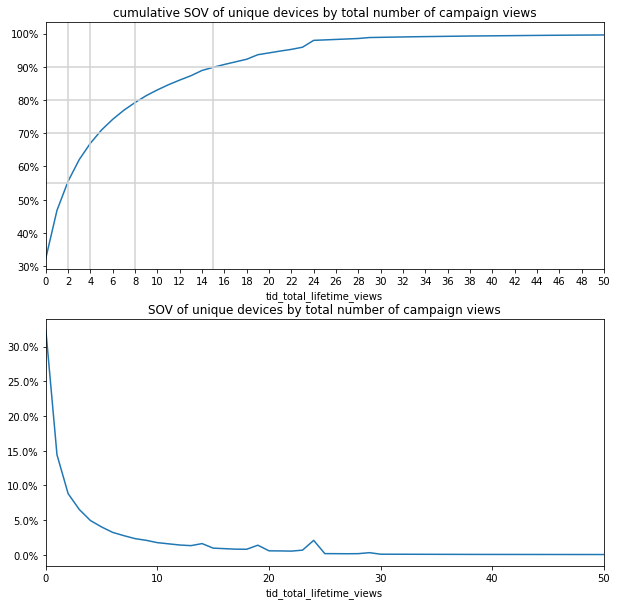

In [31]:
fig, ax = plt.subplots(2,1, figsize = (10,10))
pivot['unique_tid_cum_sov'].plot(ax = ax[0], title = 'cumulative SOV of unique devices by total number of campaign views')
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[0].set_xlim(0,50)
ax[0].set_xticks(range(0,52,2))
ax[0].axhline(y = 55, color = 'lightgrey')
ax[0].axvline(x = 2, color = 'lightgrey')
ax[0].axhline(y = 70, color = 'lightgrey')
ax[0].axvline(x = 4, color = 'lightgrey')
ax[0].axhline(y = 80, color = 'lightgrey')
ax[0].axvline(x = 8, color = 'lightgrey')
ax[0].axhline(y = 90, color = 'lightgrey')
ax[0].axvline(x = 15, color = 'lightgrey')
pivot['unique_tid_sov'].plot(ax = ax[1], title = 'SOV of unique devices by total number of campaign views')
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[1].set_xlim(0,50)

# number of days served

In [32]:
g = 'day_number_total'
pivot = (256/k)*df.pivot_table(values = ['impressions','clicks','installs','spend','cost','tid'], index = g
                                     , aggfunc = {'impressions':np.sum, 'clicks':np.sum,'installs':np.sum
                                                 ,'spend':np.sum, 'cost':np.sum, 'tid':lambda x:len(x.unique())})
pivot['imp_sov'] = 100*pivot['impressions']/pivot['impressions'].sum()
pivot['spend_sov'] = 100*pivot['spend']/pivot['spend'].sum()
pivot['cost_sov'] = 100*pivot['cost']/pivot['cost'].sum()
pivot['cum_cost_sov'] = 100*pivot['cost'].cumsum()/pivot['cost'].sum()
pivot['profit'] = pivot['spend'] - pivot['cost']
pivot['margin'] = 100*np.where(pivot['spend']>0, pivot['profit']/pivot['spend'], np.nan)
pivot['ctr'] = 100*pivot['clicks']/pivot['impressions']
pivot['ir'] = 100*pivot['installs']/pivot['clicks']
pivot['ipm'] = 1000*pivot['installs']/pivot['impressions']

cols = ['tid','imp_sov','ctr','ir','ipm','installs','spend','spend_sov','cost','cost_sov','cum_cost_sov','profit','margin']
format_pivot = pivot.loc[pivot.index <= 20, cols].style.format(format_map)
format_pivot = format_pivot.background_gradient(cmap = cm, subset = ['imp_sov','spend_sov','cost_sov','cum_cost_sov','ctr','ir','ipm','margin'])
format_pivot = format_pivot.applymap(lambda x:'background-color:white; color:white' if np.isnan(x) else '')
format_pivot


(0.0, 3.0205399688662316)

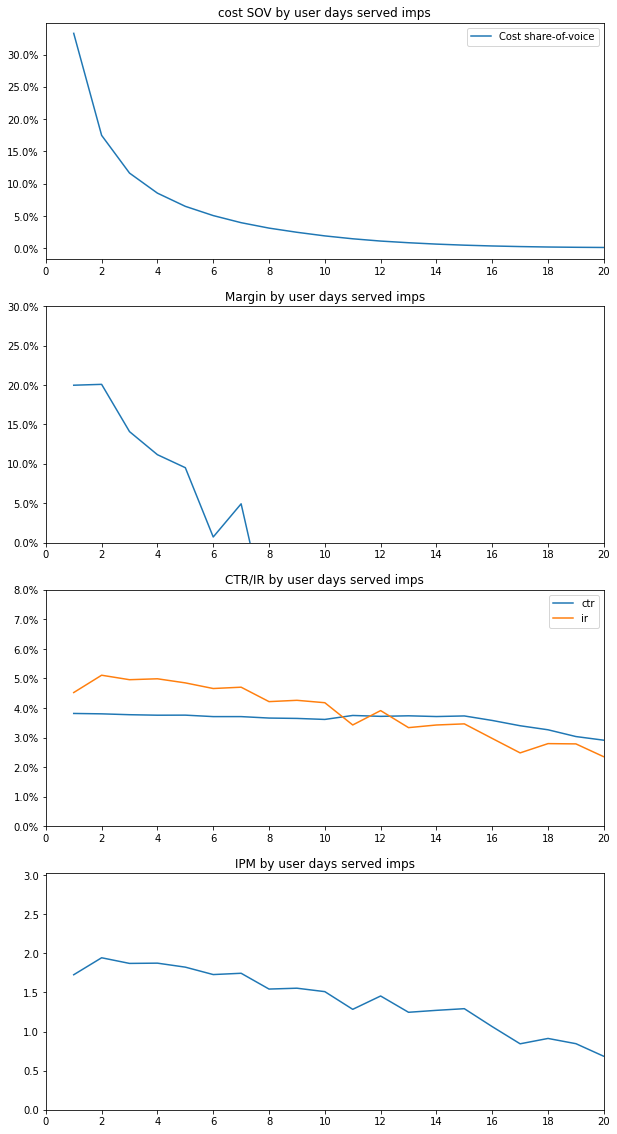

In [33]:
cols = ['imp_sov','ipm','margin']

fig, ax = plt.subplots(4,1,figsize = (10,20))
ax[0].plot(pivot.loc[:, ['cost_sov']])
ax[0].set_xlim([0,20])
ax[0].set_xticks(range(0,22,2))
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[0].set_title('cost SOV by user days served imps')
ax[0].legend(['Cost share-of-voice','Spend share-of-voice'])
ax[1].plot(pivot.loc[:, 'margin'])
ax[1].set_title('Margin by user days served imps')
ax[1].set_ylim([0,30])
ax[1].set_xlim([0,20])
ax[1].set_xticks(range(0,22,2))
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[2].plot(pivot.loc[:, ['ctr','ir']])
ax[2].legend(['ctr','ir'])
ax[2].set_title('CTR/IR by user days served imps')
ax[2].set_xlim([0,20])
ax[2].set_ylim([0,8])
ax[2].set_xticks(range(0,22,2))
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[3].plot(pivot.loc[:, ['ipm']])
ax[3].set_title('IPM by user days served imps')
ax[3].set_xlim([0,20])
ax[3].set_xticks(range(0,22,2))
ymax = pivot.loc[1,'ipm']*1.75
ax[3].set_ylim([0,ymax])

# campaigns by max (daily) views

max_views = max daily impressions

In [78]:
df_campaigns = bigquery_client.query(f"""
select
    *
from metadata.campaigns c
""").to_dataframe()
json_struct = df_campaigns['extra_data'].apply(json.loads)
df_campaigns_flat = pd.json_normalize(json_struct) 
df_campaigns_joined = df_campaigns.join(df_campaigns_flat)
df_campaigns_joined.drop(['extra_data'], axis = 1, inplace = True)
df_campaigns_joined.rename(columns = {'uuid':'ssb_campaign_uuid', 'name':'campaign_name','id':'campaign_id'}, inplace = True)

In [79]:
df_campaigns_joined.columns.tolist()

['campaign_name',
 'created_at',
 'end_at',
 'ssb_campaign_uuid',
 'country',
 'status',
 'vertical_tag',
 'form_factor',
 'platform',
 'enabled',
 'offer_id',
 'start_at',
 'campaign_id',
 'sponsored_app_id',
 'updated_at',
 'ssb_buyer_id',
 'last_enabled_at',
 'max_views',
 'model_optimize',
 'connectivity',
 'click_url',
 'maxmind_mask',
 'geo_cities_target_type',
 'zipcodes_target_type',
 'device_models_target_type',
 'os_vers_target_type',
 'maxmind_carrier_codes_target_type',
 'ip_ranges_target_type',
 'age_ranges_target_type',
 'carrier_ids_target_type',
 'time_of_week_target_type',
 'gender_target_type',
 'target_user_lists',
 'tags',
 'day_of_week',
 'time_fencing',
 'geo_cities',
 'zipcodes',
 'device_models',
 'os_vers',
 'maxmind_carrier_codes',
 'ip_ranges',
 'age_ranges',
 'carrier_ids',
 'time_of_week',
 'gender',
 'admin_only',
 'media_plan_daily_budget',
 'last_disabled_at',
 'media_scan_settings.max_wins',
 'media_scan_settings.max_installs',
 'media_scan_settings.max

In [80]:
df_campaigns_joined['experience_type'] = df_campaigns_joined.apply(lambda x:classify_campaigns(x), axis = 1)

In [81]:
df_offers = bigquery_client.query(f"""
select
    *
from metadata.offers c
""").to_dataframe()
json_struct = df_offers['extra_data'].apply(json.loads)
df_offers_flat = pd.json_normalize(json_struct) 
df_offers_joined = df_offers.join(df_offers_flat)
df_offers_joined.drop(['extra_data'], axis = 1, inplace = True)
df_offers_joined.rename(columns = {'uuid':'ssb_campaign_uuid', 'name':'offer_name','id':'offer_id'}, inplace = True)

In [82]:
by_line_campaign = bigquery_client.query(f"""
select 
    exploration_uuid
    , ssb_campaign_uuid
    , 16*sum(if(event_type = 'install',revenue,0)) revenue
    , 16*sum(if(event_type = 'clear',settlement_price,0))/1000 cost
from stats.rows1 r 
where 
    date >= '{start_dt}' and date <= '{end_dt}'
    and right(id,1) = '0'
group by 1,2 order by 3 desc, 4 desc 
""").to_dataframe()

In [83]:
top_lines = by_line_campaign.groupby('exploration_uuid')['revenue'].sum().sort_values(ascending = False).index[:1000]
df_lines = bigquery_client.query(f"""
select
    *
from metadata.lines c
where uuid in {tuple(top_lines)}
""").to_dataframe()
json_struct = df_lines['extra_data'].apply(json.loads)
df_lines_flat = pd.json_normalize(json_struct) 
df_lines_joined = df_lines.join(df_lines_flat)
df_lines_joined.drop(['extra_data'], axis = 1, inplace = True)
df_lines_joined.rename(columns = {'uuid':'exploration_uuid', 'name':'line_name','id':'line_id'}, inplace = True)

In [84]:
pivot = df_campaigns_joined.loc[:,['ssb_buyer_id','campaign_name','ssb_campaign_uuid','max_views','experience_type']]
by_campaign = by_line_campaign.groupby('ssb_campaign_uuid')['revenue','cost'].sum()
by_campaign_maxviews = by_campaign.join(pivot.set_index('ssb_campaign_uuid')).reset_index().set_index(['campaign_name','ssb_campaign_uuid','ssb_buyer_id'])
by_campaign_maxviews.sort_values('revenue',ascending = False, inplace = True)
by_campaign_maxviews[by_campaign_maxviews.max_views>3].head(30)

<ipython-input-84-b490c4a6f0f8>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_campaign = by_line_campaign.groupby('ssb_campaign_uuid')['revenue','cost'].sum()


revenue  \
campaign_name                                      ssb_campaign_uuid                ssb_buyer_id             
Particle Media – News Break – US – All – GP - D... 16d935fca4ea8b4dffa296ba147ec7df 3549          32832.00   
MLB_MP_WINCLAP_AO_W_W-ALL_APPD_ALLP_CONV_PROSP_... 90ea0b95f5b866a4c7d6c5de1d0e195d 1343          21340.80   
Audible_UK_And_Jul20_AUK005                        1ec8f228df42e1edb05e10af0881bc76 674           19136.00   
MercadoLibre_Winclap_Appreciate_Android_BR         16dd6a2d270567b7135d8b38c8ea5c14 1343          11383.20   
MLA_MP_WINCLAP_AO_W_W-ALL_APPD_ALLP_CONV_PROSP_... 654ae5affcbc79abb335dae3112abaf6 1343           8928.00   
Ualá_AR_Android                                    a5b3abf76574e1341589891def860937 1343           8112.00   
Luno_Android_ZA_banner                             10c95351993ca9ea51296d3aaa4c8205 3988           7296.00   
MercadoLibre_Winclap_Appreciate_Android_MX         d448cdbd0cda835031d80764b80a985d 1343           6361.60   
MercadoLibre_Winclap_Appreciate_Android_CL         4fd8397fa82689d0b6d0e6485dff3fcc 1343           4080.00   
display_winclap-appreciate_pax_BR-national-allc... ebfa0249cb6b108f1e921c7c670a12e2 3910           2722.88   
GoJek-ID_Android_Dec18_PTA001                      28a6f803d912053e27f555ead140e0e3 674            2496.00   
EG_VF_TOPGAMES_FARM_NEW                            6ee2a39e32aa7a146d233b978f9f7134 1528           2396.16   
FR Orange Kidjo iOS Video New                      34e4c4857143ef4a5addc96560b21f5e 852            2288.00   
FR Orange Cartoon Network Android Banners          1fb0be5f6a2e1501d57283a3b3a77866 852            2112.00   
TangleMaster3D_UK_iOS                              6e8fa0e5f8e4191681090ce86de01c68 3246           2064.00   
Telecoming-FR-Fortnite-BT-iOS                      3493aba81221e4f8ee3296325e5963a9 1437           1920.00   
Myntra_Android_Aug21_MYN001                        98d7fa962f6d323fcd76e73f1133380a 674            1891.68   
EG_VF_TOPGAMES_VIRUS_NEW_R                         85c1633be3bd04ed1acff572788d7236 1528           1699.84   
US - Mesothelioma Lawyer - Arbitrage - NEW         9e2ccfcb975c85d050acc707d71b7e0a 1528           1504.00   
UZ Beeline Games                                   0340622e954ab53be68c56a2099fe59c 1723           1497.60   
US - Asset Management - New - Arbitrage            e28b043b3f5ae771d9d3451db6461d0a 1528           1464.00   
US - Urgent Care Emr - Arbitrage                   22e791f780ac45383a60fb07f1da3154 1528           1352.00   
US - Mesothelioma Survival Rates - Arbitrage       f50421e205c70a8b7e5509cce3e75760 1528           1280.00   
UZ Ucell Apps Samsung                              0937ad3caa33ab748aa9aca12af50d51 1723           1276.80   
US - Plumber - Arbitrage - New - Bidberry2         eaec1223478e8eaf4ae88f773aa883a4 1528           1272.00   
UA Vodafone AppsClub IP Ranges                     96a7ab54d6774570ca944f7de3a3ca4c 1723           1252.80   
UA Vodafone Kids NewLaunch                         7f54e787852d70ae040ac020ec99c4f0 1723           1180.80   
US - Personal Injury Lawyer - Arbitrage            51b4f445c4c0af46a7d2aa85df88f184 1528           1152.00   
US - Charity - Arbitrage                           134e84139c4068aed4a6e6735eb193ae 1528            916.80   
UZ Beeline Fantasy                                 2b65203d28e4f08a9ab24bb68c187c09 1723            887.04   

                                                                                                          cost  \
campaign_name                                      ssb_campaign_uuid                ssb_buyer_id                 
Particle Media – News Break – US – All – GP - D... 16d935fca4ea8b4dffa296ba147ec7df 3549          23069.397210   
MLB_MP_WINCLAP_AO_W_W-ALL_APPD_ALLP_CONV_PROSP_... 90ea0b95f5b866a4c7d6c5de1d0e195d 1343          11686.908157   
Audible_UK_And_Jul20_AUK005                        1ec8f228df42e1edb05e10af0881bc76 674            8771.797083   
MercadoL

In [85]:
is_dt = (by_campaign_maxviews.index.get_level_values(2) == 3549)
i = 'max_views'
pivot = by_campaign_maxviews[is_dt].reset_index().fillna(-1).pivot_table(values = ['revenue','cost','campaign_name'], index = i, aggfunc = {'revenue':np.sum, 'cost':np.sum,'campaign_name':lambda x:len(x.unique())})
pivot['profit'] = pivot['revenue'] - pivot['cost']
pivot['margin'] = 100*pivot['profit']/np.maximum(1,pivot['revenue'])
pivot['revenue_sov'] = 100*pivot.revenue/pivot['revenue'].sum()

pivot_nondt = by_campaign_maxviews[~is_dt].reset_index().fillna(-1).pivot_table(values = ['revenue','cost','campaign_name'], index = i, aggfunc = {'revenue':np.sum, 'cost':np.sum, 'campaign_name':lambda x:len(x.unique())})
pivot_nondt['profit'] = pivot_nondt['revenue'] - pivot_nondt['cost']
pivot_nondt['margin'] = 100*pivot_nondt['profit']/np.maximum(1,pivot_nondt['revenue'])
pivot_nondt['revenue_sov'] = 100*pivot_nondt.revenue/pivot_nondt['revenue'].sum()

cols = ['campaign_name','revenue','profit','margin','revenue_sov']
pivot_joined = pivot[cols].join(pivot_nondt[cols], lsuffix = ' dt', rsuffix = ' non dt', how = 'outer').fillna(0)
pivot_joined.style.format('{:,.0f}%').format({'profit dt':'${:,.0f}','profit non dt':'${:,.0f}','revenue dt':'${:,.0f}','revenue non dt':'${:,.0f}','campaign_name dt':'{:,.0f}','campaign_name non dt':'{:,.0f}'}).background_gradient(cmap=cm, subset  = ['profit dt','profit non dt','margin dt','margin non dt','revenue_sov dt','revenue_sov non dt'])


In [86]:
i = 'max_views'
pivot = by_campaign_maxviews[is_dt].reset_index().fillna(-1).pivot_table(values = ['revenue','cost','campaign_name'], index = ['experience_type',i], aggfunc = {'revenue':np.sum, 'cost':np.sum,'campaign_name':lambda x:len(x.unique())})
pivot['profit'] = pivot['revenue'] - pivot['cost']
pivot['margin'] = 100*pivot['profit']/np.maximum(1,pivot['revenue'])
pivot['revenue_sov'] = 100*pivot.revenue/pivot['revenue'].sum()
pivot[cols].style.format('{:,.0f}%').format({'profit':'${:,.0f}','revenue':'${:,.0f}','campaign_name':'{:,.0f}'}).background_gradient(cmap=cm, subset  = ['profit','margin','revenue_sov'])

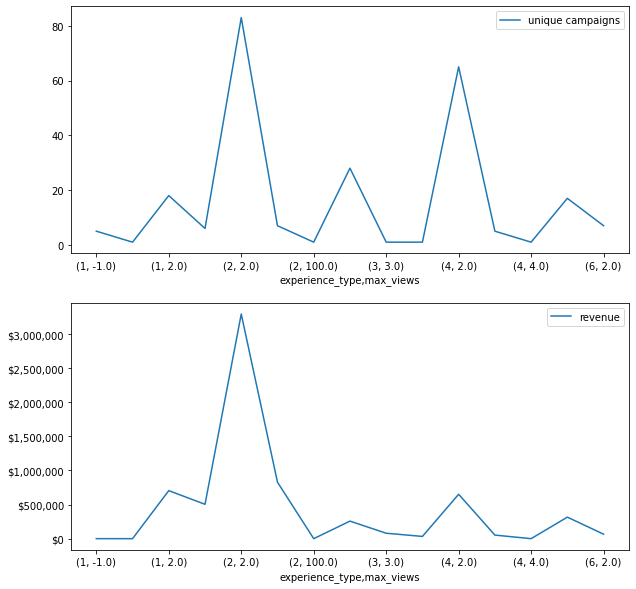

In [87]:
fig, ax = plt.subplots(2,1,figsize = (10,10))
pivot['campaign_name'].plot(ax = ax[0])
ax[0].legend(['unique campaigns'])
pivot['revenue'].plot(ax = ax[1])
ax[1].legend(['revenue'])
ax[1].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

In [88]:
pivot = df_lines_joined.loc[:,['ssb_buyer_id','line_id','campaign_id','exploration_uuid','max_views']]
by_line = by_line_campaign.groupby('exploration_uuid')['revenue'].sum().to_frame()
by_line_maxviews = by_line.join(pivot.set_index('exploration_uuid'))
by_line_maxviews.set_index(['ssb_buyer_id','line_id','campaign_id'], inplace = True)
by_line_maxviews.sort_values('revenue',ascending = False, inplace = True)
by_line_maxviews[by_line_maxviews.max_views>0].head(30)

revenue  max_views
ssb_buyer_id line_id   campaign_id                    
3549.0       1028917.0 415.0         6396.0        3.0
             1030658.0 415.0         5160.0        3.0
1343.0       104944.0  46.0          4160.0        4.0
3549.0       1858031.0 166.0         2451.2        3.0
             1028295.0 415.0         2364.0        3.0
1343.0       82386.0   46.0          1185.6        4.0
3549.0       1173949.0 415.0         1032.0        3.0

In [89]:
pivot = by_line_maxviews.reset_index().fillna(-1).pivot_table(values = ['revenue','line_id'], index = 'max_views', aggfunc = {'revenue':np.sum, 'line_id':lambda x:len(x.unique())})
pivot.style.format('{:,.0f}')

In [90]:
maxviews_campaigns = by_campaign_maxviews[by_campaign_maxviews.max_views == 3].index.get_level_values(1).tolist()
g = 'imp_number_total_day'
pivot = (256/k)*df[df.ssb_campaign_uuid.isin(maxviews_campaigns)].pivot_table(values = ['impressions','clicks','installs','spend','cost','tid'], index = g
                                     , aggfunc = {'impressions':np.sum, 'clicks':np.sum,'installs':np.sum
                                                 ,'spend':np.sum, 'cost':np.sum, 'tid':lambda x:len(x.unique())})
pivot['imp_sov'] = 100*pivot['impressions']/pivot['impressions'].sum()
pivot['spend_sov'] = 100*pivot['spend']/pivot['spend'].sum()
pivot['cost_sov'] = 100*pivot['cost']/pivot['cost'].sum()
pivot['cum_cost_sov'] = 100*pivot['cost'].cumsum()/pivot['cost'].sum()
pivot['profit'] = pivot['spend'] - pivot['cost']
pivot['margin'] = 100*np.where(pivot['spend']>0, pivot['profit']/pivot['spend'], np.nan)
pivot['ctr'] = 100*pivot['clicks']/pivot['impressions']
pivot['ir'] = 100*pivot['installs']/pivot['clicks']
pivot['ipm'] = 1000*pivot['installs']/pivot['impressions']

cols = ['tid','imp_sov','ctr','ir','ipm','installs','spend','spend_sov','cost','cost_sov','cum_cost_sov','profit','margin']
format_pivot = pivot.loc[pivot.index <= 20, cols].style.format(format_map)
format_pivot = format_pivot.background_gradient(cmap = cm, subset = ['imp_sov','spend_sov','cost_sov','cum_cost_sov','ctr','ir','ipm','margin'])
format_pivot = format_pivot.applymap(lambda x:'background-color:white; color:white' if np.isnan(x) else '')
format_pivot


~95% of cost/impressions are happening within the firxt X impressions on the users  for the day, as set for these campaigns.

In [91]:
pivot = df_campaigns_joined.loc[df_campaigns_joined.ssb_buyer_id == 3549, ['campaign_id','max_views']]
pivot['link'] = pivot.apply(lambda x:'https://www.tpbid.com/ssb/3549/campaigns/'+str(int(x.campaign_id))+'/edit#/settings', axis = 1)

filters = (pivot.max_views == 3)
pivot[filters].head(20)
for i in range(20):
    print(pivot[filters].iloc[i,2])

https://www.tpbid.com/ssb/3549/campaigns/163/edit#/settings
https://www.tpbid.com/ssb/3549/campaigns/449/edit#/settings
https://www.tpbid.com/ssb/3549/campaigns/14/edit#/settings
https://www.tpbid.com/ssb/3549/campaigns/31/edit#/settings
https://www.tpbid.com/ssb/3549/campaigns/40/edit#/settings
https://www.tpbid.com/ssb/3549/campaigns/41/edit#/settings
https://www.tpbid.com/ssb/3549/campaigns/42/edit#/settings
https://www.tpbid.com/ssb/3549/campaigns/43/edit#/settings
https://www.tpbid.com/ssb/3549/campaigns/45/edit#/settings
https://www.tpbid.com/ssb/3549/campaigns/46/edit#/settings
https://www.tpbid.com/ssb/3549/campaigns/47/edit#/settings
https://www.tpbid.com/ssb/3549/campaigns/89/edit#/settings
https://www.tpbid.com/ssb/3549/campaigns/147/edit#/settings
https://www.tpbid.com/ssb/3549/campaigns/172/edit#/settings
https://www.tpbid.com/ssb/3549/campaigns/298/edit#/settings
https://www.tpbid.com/ssb/3549/campaigns/332/edit#/settings
https://www.tpbid.com/ssb/3549/campaigns/361/edit#

# campaigns by max lifetime views

In [92]:
pivot = df_campaigns_joined.loc[:,['ssb_buyer_id','campaign_name','ssb_campaign_uuid','max_lifetime_views']]
by_campaign = by_line_campaign.groupby('ssb_campaign_uuid')['revenue','cost'].sum()
by_campaign_max_lifetime_views = by_campaign.join(pivot.set_index('ssb_campaign_uuid')).reset_index().set_index(['campaign_name','ssb_campaign_uuid','ssb_buyer_id'])
by_campaign_max_lifetime_views.sort_values('revenue',ascending = False, inplace = True)
by_campaign_max_lifetime_views[by_campaign_max_lifetime_views.max_lifetime_views>3].head(30)

<ipython-input-92-4744d470e4c1>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_campaign = by_line_campaign.groupby('ssb_campaign_uuid')['revenue','cost'].sum()


revenue  \
campaign_name                                  ssb_campaign_uuid                ssb_buyer_id              
Position Mobile – Weather Home – US – UA       4c7f5d9964abdca5793b3d48f13fe6f9 3549          739891.20   
Position Mobile - Weather Home - US - UA - VZW f170d605138818f15d91db49b1bf498e 3549          670919.20   
Particle Media - News Break - US - VZW PR      60afc4f294695ffe7ea525534f019d20 3549          339926.40   
Android-SmartNews Inc-SmartNews-US-VZ-2        099a5d47e9bf3796c1b9ca5c5f4bc264 3549          208188.80   
Pandora - Pandora - US - 4 -banner/native      377f69bc9e2d613ee60d07d1df5897d5 3549          200003.20   
Pandora - Pandora - US - 1                     30bc823acca34196010b05475c5d77ec 3549          155406.40   
DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA-VZW 32306faf44c94f31443228da180c50c7 3549          135112.00   
Android-Twitter-Twitter-PK-4                   962d52a1a1605f0086dcff2e9da3cada 3549          134380.80   
SmartNews_Verizon_SingleTap_All_CPI_NA         5fef83d15c5b811b424ed58aeb82d0a7 3549          122590.40   
Particle Media - News Break - US - VZW UA      c5534bbfcb4dccdd122f22da877a6f78 3549          120000.00   
Android-Magazine Luiza-Magazine Luiza-BR-2     4602e704fb2f737aef26a2ddb7459a66 3549          116245.28   
DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA     3bf043901874bb0ef510dc88b8a764ad 3549          114555.20   
Pandora - Pandora - US - 2 - Cricket/Tracfone  a60b75e69079fb3b46baf01c061b7a58 3549          107382.40   
Android-Grupo Coppel-Coppel-MX-2-Blend         6511f9bd6121500fa4082bc1209ad8d1 3549          104160.00   
SmartNews_ATT_SingleTap_All_CPI_NA             33bff90d655b976e9399f1d0b0463d22 3549           98219.20   
Android-CEA-CEA-BR-2                           9adb91f88b6b2579425c8e10415c31b5 3549           91116.80   
Pandora - Pandora - US - 5 - video/inter       98c8dd0b6002efbfd969ad68d989181d 3549           90464.00   
SmartNews_Tracfone_SingleTap_All_CPI_NA        d8be47c87ebd5047c552f92421103f1a 3549           83286.40   
Android-Curated Content-Solitaire-US-2         4bc6018c8c12d727bf2fc8bc99b47d0e 3549           81271.20   
Pandora - Pandora - US - iOS                   8f6af55d3b890df1566e59c4bcf13d3c 3549           80112.00   
Twitter - Twitter - BR - UA                    292906bbb71deaebb880439ce8c72995 3549           80065.60   
Particle Media – News Break – US – All – GP2   95f82f59fd9cac3b272b560f722e35d6 3549           79644.80   
Particle Media - News Break - US - ATT PR      b291b1c34d27bb722c2a3cd95748e5f0 3549           78948.00   
Android-Twitter-Twitter-EG-2                   fad842726082aa12e048b2e0e8cb8c7a 3549           77309.60   
Android-Magazine Luiza-Magazine Luiza-BR-1     08fe51b89505b4d57731d507f439979d 3549           66349.76   
DT-SingleTap-DSP-PlaySimple-WordJam-US-UA-VZW  77ccedb79a68bd2e9466197cb01ada53 3549           66096.00   
Playsimple-Word Jam-US-RON                     d68c7b0af30354df7c23485a57b8f17e 3549           57600.00   
Android-SmartNews Inc-SmartNews-US-ATT-2       460c77fda3ba6cdf651311f5eedb7187 3549           54481.60   
Weedmaps-Weedmaps-US-UA                        4c2507672d44889680be77f2422c91ac 3549           52704.00   
Android-SmartNews Inc-SmartNews-US-Tracfone-2  d018489d8075c72fa12c6bf0e7f54fbb 3549           50918.40   

                                                                                                      cost  \
campaign_name                                  ssb_campaign_uuid                ssb_buyer_id                 
Position Mobile – Weather Home – US – UA       4c7f5d9964abdca5793b3d48f13fe6f9 3549          1.012513e+06   
Position Mobile - Weather Home - US - UA - VZW f170d605138818f15d91db49b1bf498e 3549          6.837861e+05   
Particle Media - News Break - US - VZW PR      60afc4f294695ffe7ea525534f019d20 3549          2.788560e+05   
Android-SmartNews Inc-SmartNews-US-VZ-2        099a5d47e9bf3796c1b9ca5c5f4bc264 3549          2.144571e+05   
Pandora - P

In [93]:
is_dt = (by_campaign_max_lifetime_views.index.get_level_values(2) == 3549)
i = 'max_lifetime_views'
pivot = by_campaign_max_lifetime_views[is_dt].reset_index().fillna(-1).pivot_table(values = ['revenue','cost','campaign_name'], index = i, aggfunc = {'revenue':np.sum, 'cost':np.sum,'campaign_name':lambda x:len(x.unique())})
pivot['margin'] = 100*(pivot['revenue']-pivot['cost'])/np.maximum(1,pivot['revenue'])
pivot['revenue_sov'] = 100*pivot.revenue/pivot['revenue'].sum()

pivot_nondt = by_campaign_max_lifetime_views[~is_dt].reset_index().fillna(-1).pivot_table(values = ['revenue','cost','campaign_name'], index = i, aggfunc = {'revenue':np.sum, 'cost':np.sum, 'campaign_name':lambda x:len(x.unique())})
pivot_nondt['margin'] = 100*(pivot_nondt['revenue']-pivot_nondt['cost'])/np.maximum(1,pivot_nondt['revenue'])
pivot_nondt['revenue_sov'] = 100*pivot_nondt.revenue/pivot_nondt['revenue'].sum()

cols = ['campaign_name','revenue','margin','revenue_sov']
pivot_joined = pivot[cols].join(pivot_nondt[cols], lsuffix = '_dt', rsuffix = '_non_dt', how = 'outer').fillna(0)
pivot_joined.style.format('{:,.0f}%').format({'cost_dt':'${:,.0f}','cost_non_dt':'${:,.0f}','revenue_dt':'${:,.0f}','revenue_non_dt':'${:,.0f}','campaign_name_dt':'{:,.0f}','campaign_name_non_dt':'{:,.0f}'}).background_gradient(cmap=cm, subset  = ['margin_dt','margin_non_dt','revenue_sov_dt','revenue_sov_non_dt'])


Most have a max lifetime views of 25 for DT. this seems roughly similar to non-DT.

Looking at the margin curve (above), it seems we are still at positive margin at longer lifetime views. 

# Could we have gotten organics?

In [94]:
query_organics = """
select
    tid
    , bundle
    , max(t_created) as install_ts
from external_data.ext_data
where
    type = 'install'
    and is_attributed = FALSE
    and date(t_created) >= '{start_dt}'
    and date(t_created) <= '{end_dt}'+30
    and right(tid,2) = '{n}0'
group by 1,2
"""
df_list = []
for n in list(range(k)):
    print(f'Running query {n+1} of {k}')
    sub_df = bigquery_client.query(query_organics.format(start_dt = start_dt, end_dt = end_dt, n = n)).to_dataframe()
    df_list.append(sub_df)
df_organics = pd.concat(df_list)

Running query 1 of 1


Filtering for CPI campaigns (everything is CPI?). 

looking at profit numbers - daily views 4 and 5 are net positive.

Impression -> organic install time, 

theory - if we served another impression, we would have gotten the organic install. impression vs click attribution. By campaign to represent potential opportunity. 

by experience type - Verizon (exp 5), Samsung (exp 6 non-us)

In [95]:
bundles_w_organics = df_organics.bundle.unique().tolist()
df['organic_avail'] = df.sponsored_bnd.isin(bundles_w_organics)
(256/k)*df.groupby('organic_avail')['cost'].sum()

organic_avail
False    1.760136e+06
True     4.676870e+06
Name: cost, dtype: float64

In [96]:
cols = ['tid','etimestamp','sponsored_bnd','campaign_name','ssb_campaign_uuid','ad_type','impression type','imp_number_total_day']
df['device_installs'] = df.groupby(['tid','sponsored_bnd'])['installs'].transform(sum)
no_install_df = df.loc[(df.organic_avail) & (df.device_installs == 0), cols]

joined = pd.merge(no_install_df, df_organics, left_on = ['tid','sponsored_bnd'], right_on = ['tid','bundle'], how = 'left')
joined

tid                etimestamp  \
0        000006623b96c746957022b2910d1400 2021-10-06 15:34:04+00:00   
1        000006623b96c746957022b2910d1400 2021-10-06 15:34:11+00:00   
2        000006623b96c746957022b2910d1400 2021-10-06 22:51:10+00:00   
3        00000efd05d6fb41bc80d9de4585b600 2021-09-10 23:21:21+00:00   
4        0000100c9344d223d2871a252999f500 2021-09-25 14:04:17+00:00   
...                                   ...                       ...   
6037842  ffffe78ea3488b3d2e15932d48904300 2021-09-23 12:01:37+00:00   
6037843  ffffe78ea3488b3d2e15932d48904300 2021-09-23 12:02:01+00:00   
6037844  fffff69ddb969d3307a0fdfe465a4200 2021-09-25 03:25:58+00:00   
6037845  fffff69ddb969d3307a0fdfe465a4200 2021-09-25 03:28:56+00:00   
6037846  fffffe7497a7c621719eef3f80fefc00 2021-09-20 23:31:44+00:00   

                   sponsored_bnd                               campaign_name  \
0            com.twitter.android            Twitter - Twitter - BR - True GP   
1            com.twitter.android            Twitter - Twitter - BR - True GP   
2            com.twitter.android            Twitter - Twitter - BR - True GP   
3                      284035177                Pandora - Pandora - US - iOS   
4           com.dna.solitaireapp      Android-Curated Content-Solitaire-US-4   
...                          ...                                         ...   
6037842  com.king.candycrushsaga         Android-King-Candy Crush-BR-2-Video   
6037843  com.king.candycrushsaga         Android-King-Candy Crush-BR-2-Video   
6037844     com.coppel.coppelapp      Android-Grupo Coppel-Coppel-MX-2-Blend   
6037845     com.coppel.coppelapp      Android-Grupo Coppel-Coppel-MX-2-Blend   
6037846      com.luizalabs.mlapp  Android-Magazine Luiza-Magazine Luiza-BR-2   

                        ssb_campaign_uuid ad_type impression type  \
0        b7c89cdb901658c9b5cde8b89203d0f0   inter           video   
1        b7c89cdb901658c9b5cde8b89203d0f0   inter           video   
2        b7c89cdb901658c9b5cde8b89203d0f0  banner          native   
3        8f6af55d3b890df1566e59c4bcf13d3c  banner         display   
4        8037543af9d2c29047e28f3ea5a65139  banner         display   
...                                   ...     ...             ...   
6037842  e3db357a67cddf2bbe81b4f46fe2c38d   inter           video   
6037843  e3db357a67cddf2bbe81b4f46fe2c38d   inter           video   
6037844  6511f9bd6121500fa4082bc1209ad8d1   inter           video   
6037845  6511f9bd6121500fa4082bc1209ad8d1   inter           video   
6037846  4602e704fb2f737aef26a2ddb7459a66  banner         display   

         imp_number_total_day bundle install_ts  
0                           1    NaN        NaT  
1                           1    NaN        NaT  
2                           2    NaN        NaT  
3                           1    NaN        NaT  
4                           1    NaN        NaT  
...                       ...    ...        ...  
6037842                     1    NaN        NaT  
6037843                     1    NaN        NaT  
6037844                     1    NaN        NaT  
6037845                     2    NaN        NaT  
6037846                     1    NaN        NaT  

[6037847 rows x 10 columns]

In [97]:
joined['max_touch_ts'] = joined.groupby(['tid','sponsored_bnd'])['etimestamp'].transform(max)
joined['tti'] = np.where(joined.max_touch_ts == joined.etimestamp, (joined.install_ts - joined.max_touch_ts).dt.total_seconds()/3600, np.nan)

joined = pd.merge(joined, df_campaigns_joined[['ssb_campaign_uuid','max_views']], on = 'ssb_campaign_uuid')
joined['last_impression'] = joined.imp_number_total_day == joined.max_views
joined

tid                etimestamp  \
0        000006623b96c746957022b2910d1400 2021-10-06 15:34:04+00:00   
1        000006623b96c746957022b2910d1400 2021-10-06 15:34:11+00:00   
2        000006623b96c746957022b2910d1400 2021-10-06 22:51:10+00:00   
3        0005a732f72f26ee3e40a7819edc3c00 2021-09-22 22:44:38+00:00   
4        0005a732f72f26ee3e40a7819edc3c00 2021-09-22 23:11:47+00:00   
...                                   ...                       ...   
6037842  564e7e6959099f1bde84e25269d19800 2021-09-21 21:21:26+00:00   
6037843  564e7e6959099f1bde84e25269d19800 2021-09-23 19:54:57+00:00   
6037844  564e7e6959099f1bde84e25269d19800 2021-09-23 23:14:19+00:00   
6037845  564e7e6959099f1bde84e25269d19800 2021-09-25 17:13:00+00:00   
6037846  564e7e6959099f1bde84e25269d19800 2021-09-25 17:48:12+00:00   

                       sponsored_bnd  \
0                com.twitter.android   
1                com.twitter.android   
2                com.twitter.android   
3                com.twitter.android   
4                com.twitter.android   
...                              ...   
6037842  com.aqupepgames.projectpepe   
6037843  com.aqupepgames.projectpepe   
6037844  com.aqupepgames.projectpepe   
6037845  com.aqupepgames.projectpepe   
6037846  com.aqupepgames.projectpepe   

                                        campaign_name  \
0                    Twitter - Twitter - BR - True GP   
1                    Twitter - Twitter - BR - True GP   
2                    Twitter - Twitter - BR - True GP   
3                    Twitter - Twitter - BR - True GP   
4                    Twitter - Twitter - BR - True GP   
...                                               ...   
6037842  Android-Scopely-Looney Tunes-US-2-VIP Payers   
6037843  Android-Scopely-Looney Tunes-US-2-VIP Payers   
6037844  Android-Scopely-Looney Tunes-US-2-VIP Payers   
6037845  Android-Scopely-Looney Tunes-US-2-VIP Payers   
6037846  Android-Scopely-Looney Tunes-US-2-VIP Payers   

                        ssb_campaign_uuid ad_type impression type  \
0        b7c89cdb901658c9b5cde8b89203d0f0   inter           video   
1        b7c89cdb901658c9b5cde8b89203d0f0   inter           video   
2        b7c89cdb901658c9b5cde8b89203d0f0  banner          native   
3        b7c89cdb901658c9b5cde8b89203d0f0  banner          native   
4        b7c89cdb901658c9b5cde8b89203d0f0  banner          native   
...                                   ...     ...             ...   
6037842  fba74ebec2efee2fd0226a565238156a  banner         display   
6037843  fba74ebec2efee2fd0226a565238156a  banner          native   
6037844  fba74ebec2efee2fd0226a565238156a  banner         display   
6037845  fba74ebec2efee2fd0226a565238156a  banner         display   
6037846  fba74ebec2efee2fd0226a565238156a  banner          native   

         imp_number_total_day bundle install_ts              max_touch_ts  \
0                           1    NaN        NaT 2021-10-06 22:51:10+00:00   
1                           1    NaN        NaT 2021-10-06 22:51:10+00:00   
2                           2    NaN        NaT 2021-10-06 22:51:10+00:00   
3                           1    NaN        NaT 2021-09-22 23:11:47+00:00   
4                           2    NaN        NaT 2021-09-22 23:11:47+00:00   
...                       ...    ...        ...                       ...   
6037842                     1    NaN        NaT 2021-09-25 17:48:12+00:00   
6037843                     1    NaN        NaT 2021-09-25 17:48:12+00:00   
6037844                     2    NaN        NaT 2021-09-25 17:48:12+00:00   
6037845                     1    NaN        NaT 2021-09-25 17:48:12+00:00   
6037846                     2    NaN        NaT 2021-09-25 17:48:12+00:00   

         tti  max_views  last_impression  
0        NaN        2.0            False  
1        NaN        2.0            False  
2        NaN        2.0             True  
3        NaN        2.0            False  
4        NaN        2.0             True  
...    

<AxesSubplot:>

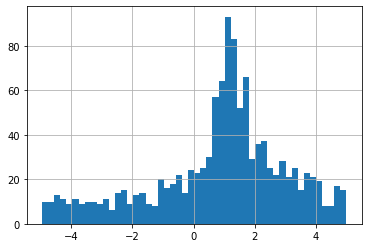

In [98]:
joined.loc[(~joined.tti.isna()) & (joined.tti >= -5) & (joined.tti <= 5), 'tti'].hist(bins = 50)

The above graph is the distribution *when there is a match between impression and unattributed install*. 

SOV of impressions/cost that is after the install?

In [99]:
organic_avail_imps_df = df.loc[(df.organic_avail) & (df.impressions > 0)]
joined_imps = pd.merge(organic_avail_imps_df, df_organics, left_on = ['tid','sponsored_bnd'], right_on = ['tid','bundle'], how = 'left')
joined_imps['tti'] = (joined_imps.install_ts - joined_imps.etimestamp).dt.total_seconds()/3600
joined_imps = pd.merge(joined_imps, df_campaigns_joined[['ssb_campaign_uuid','max_views']], on = 'ssb_campaign_uuid')
joined_imps['last_impression'] = joined_imps.imp_number_total_day == joined_imps.max_views
print(joined_imps.shape[0], joined_imps['install_ts'].count())

5845700 111361


In [100]:
(256/k)*(joined_imps[['impressions','install_ts']].count())

impressions    1.496499e+09
install_ts     2.850842e+07
dtype: float64

Text(0.5, 1.0, 'cumulative SOV of unique impressions by impression to organic install hours')

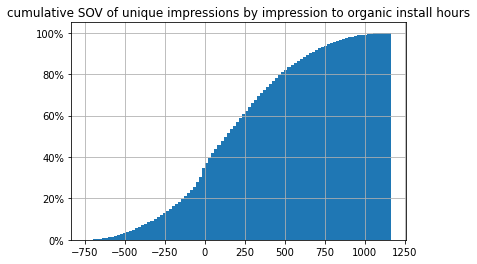

In [101]:
joined_imps['tti'].hist(cumulative = True, density = True, bins = 100)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.title('cumulative SOV of unique impressions by impression to organic install hours')

In [102]:
print((256/k)*joined_imps.cost.sum())
print((256/k)*joined_imps.loc[joined_imps.tti.isna(), 'cost'].sum())
print(100*joined_imps.loc[joined_imps.tti.isna(), 'cost'].sum()/joined_imps.cost.sum(),'%')

4676869.766163199
4549707.2912499225
97.28103451087547 %


Only 2% of the cost has an associated organic install.

In [103]:
print('cost after organic install:',(256/k)*joined_imps.loc[(joined_imps.tti < 0), 'cost'].sum())
print('cost before organic install:',(256/k)*joined_imps.loc[(joined_imps.tti >= 0), 'cost'].sum())

cost after organic install: 27673.434586368
cost before organic install: 99489.040326912


slightly more cost spent before the install. However, since ~3% of cost has an organic install joined, the loss is small.

Text(0.5, 1.0, 'installs by hour after last touch time')

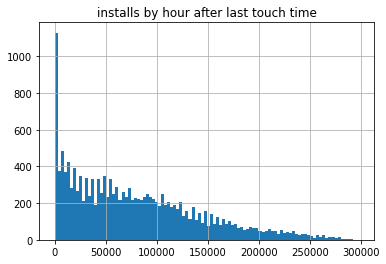

In [104]:
((256/k)*joined.loc[joined.tti >= 0, 'tti']).hist(bins = 100)
plt.title('installs by hour after last touch time')

In [105]:
hr_max = 6
print((256/k)*df.loc[(df.sponsored_bnd.isin(bundles_w_organics)), 'installs'].sum())
print((256/k)*joined.loc[(joined.tti >= 0) & (joined.tti <= hr_max), 'install_ts'].nunique())
print(100*joined.loc[(joined.tti >= 0) & (joined.tti <= hr_max), 'install_ts'].nunique()/df.loc[(df.sponsored_bnd.isin(bundles_w_organics)), 'installs'].sum(), '%')

4246528.0
229120.0
5.395466602363154 %


The percentage of installs increased if we could get attribution for organic installs within {hr_max} hours, is a slight increase

In [106]:
pivot = joined[(joined.tti > 0) & (joined.tti <= 24)].pivot_table(values = ['install_ts'], index = 'tti', aggfunc = 'nunique')
pivot['tti_h'] = pd.cut(pivot.index, bins = range(25), labels = range(1,25))
pivot = 100*pivot.groupby('tti_h')['install_ts'].sum().cumsum()/(df.loc[(df.sponsored_bnd.isin(bundles_w_organics)), 'installs'].sum())
pivot = pd.DataFrame(pivot)
pivot.loc[0] = 0
pivot.sort_index(inplace = True)

Text(0.5, 1.0, '% increase in installs by number of hours between last impression and unattributed install')

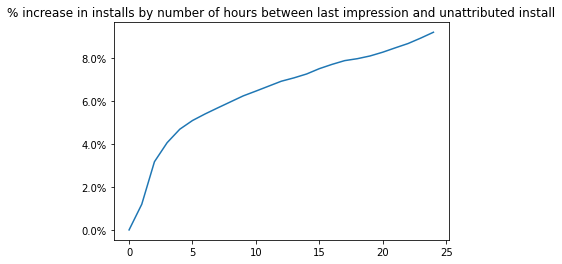

In [107]:
plt.plot(pivot)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(100))
plt.title('% increase in installs by number of hours between last impression and unattributed install')

## Distribution of second impression after first impression in a day

In [108]:
df.sort_values(['tid','ssb_campaign_uuid','date','etimestamp'], inplace = True)
df['prev_imp'] = df[df.impressions > 0].groupby(['tid','ssb_campaign_uuid','date'])['etimestamp'].shift()
df['time_since_last_imp'] = np.where((df.impressions>0), 
                                  (df.etimestamp - df.prev_imp).dt.total_seconds()
                                  , np.nan)
# check if this is behaving as expected

Text(0.5, 1.0, 'distribution of seconds since the previous impression within the day')

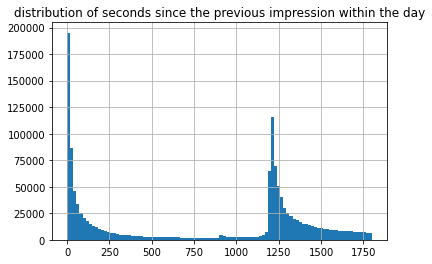

In [109]:
df.loc[(df.time_since_last_imp < 1800) & (df.time_since_last_imp >0), 'time_since_last_imp'].hist(bins = 100)
plt.title('distribution of seconds since the previous impression within the day')

Text(0.5, 1.0, 'cumulative sov distribution of seconds since last impression within the day')

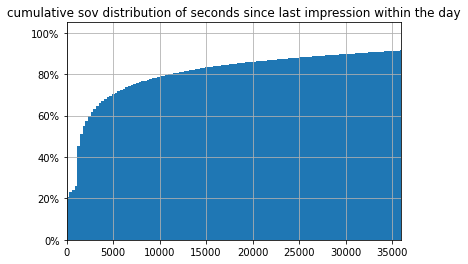

In [110]:
df['time_since_last_imp'].hist(bins = 1000, cumulative = True, density = True)
plt.gca().set_xlim(0,36000)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.title('cumulative sov distribution of seconds since last impression within the day')

Text(0.5, 1.0, 'cumulative sov distribution of seconds since last impression within the day')

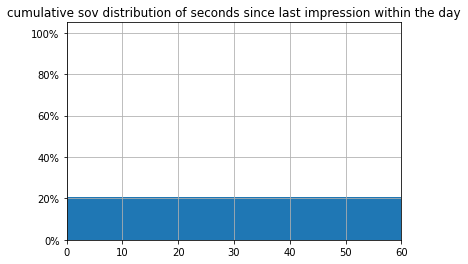

In [111]:
df['time_since_last_imp'].hist(bins = 1000, cumulative = True, density = True)
plt.gca().set_xlim(0,60)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.title('cumulative sov distribution of seconds since last impression within the day')

In [112]:
(256/k)*df['cost'].sum()

6437006.120104961

In [113]:
df['tid_campaign_ts'] = df[['tid','ssb_campaign_uuid','timestamp']].apply(lambda x:'_'.join(x.values.astype(str)), axis = 1)
quick_imps_list = df.loc[(df.time_since_last_imp < 10), 'tid_campaign_ts'].unique().tolist()
df['tid_campaign'] = df[['tid','ssb_campaign_uuid']].apply(lambda x:'_'.join(x.values.astype(str)), axis = 1)
quick_tids_list = df.loc[(df.time_since_last_imp < 10), 'tid_campaign'].unique().tolist()
by_tid_campaign = df.groupby('tid_campaign_ts')['impressions','clicks','installs','cost','spend'].sum().reset_index()

<ipython-input-113-14fe8a26c614>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_tid_campaign = df.groupby('tid_campaign_ts')['impressions','clicks','installs','cost','spend'].sum().reset_index()


In [30]:
by_tid_campaign['quick_imp'] = by_tid_campaign.tid_campaign_ts.isin(quick_imps_list)
pivot = (256/k)*by_tid_campaign.pivot_table(index = 'quick_imp', values = ['impressions','clicks','installs','spend','cost'], aggfunc = np.sum, margins = True)
pivot.sort_values('cost', ascending = False, inplace = True)
pivot['ctr'] = 100*pivot.clicks/pivot.impressions
pivot['ir'] = 100*pivot.installs/pivot.clicks
pivot['cpm'] = 1000*pivot.cost/pivot.impressions
pivot['ipm'] = 1000*pivot.installs/pivot.impressions
pivot['profit'] = pivot.spend - pivot.cost
pivot['margin'] = 100*pivot.profit/pivot.spend
pivot['rev_sov'] = 100*pivot.spend/pivot.spend.iloc[0]
pivot['cost_sov'] = 100*pivot.cost/pivot.cost.iloc[0]
pivot[['impressions','clicks','ctr','installs','ir','ipm','cpm','spend','rev_sov','cost','cost_sov','profit','margin']].style.format(format_map)

NameError: name 'by_tid_campaign' is not defined

In [115]:
quick_imp_examples = df.loc[(df.tid_campaign.isin(quick_tids_list)) & (df.impressions > 0), ['id','tid','ssb_campaign_uuid','exchange_id','hosting_bnd','timestamp','etimestamp','campaign_lifetime_views','prev_imp','time_since_last_imp','tid_campaign']]
quick_imp_examples = pd.merge(quick_imp_examples, df_campaigns_joined[['ssb_campaign_uuid','fcap_min_impressions_interval','fcap_consecutive_impressions']], on = 'ssb_campaign_uuid', how = 'left')
quick_imp_examples.sort_values(['tid','ssb_campaign_uuid','etimestamp'], inplace = True)
quick_imp_examples[:10000].to_csv(f'~/Downloads/quick_imp_examples_{start_dt}_{end_dt}.csv')
quick_imp_examples['last_imp_exchange'] = quick_imp_examples.groupby(['tid','ssb_campaign_uuid'])['exchange_id'].shift(1)
quick_imp_examples['last_imp_pub'] = quick_imp_examples.groupby(['tid','ssb_campaign_uuid'])['hosting_bnd'].shift(1)
quick_tids_diffexch_list = quick_imp_examples.loc[(quick_imp_examples.time_since_last_imp < 10) & (quick_imp_examples.last_imp_exchange != quick_imp_examples.exchange_id), 'tid_campaign'].unique().tolist()
quick_tids_diffpub_list = quick_imp_examples.loc[(quick_imp_examples.time_since_last_imp < 10) & (quick_imp_examples.last_imp_pub != quick_imp_examples.hosting_bnd), 'tid_campaign'].unique().tolist()
quick_imp_examples.iloc[100:140]#.style.background_gradient(cmap = cm, subset = ['exchange_id','campaign_lifetime_views','time_since_last_imp','imp_number_total_day'])

id  \
100  000cce680aaf5332bbb378b084c487007a0dc82abc7d10...   
101  000cce680aaf5332bbb378b084c4870071fee130d10f30...   
102  000cce680aaf5332bbb378b084c487007a7d218712eab6...   
103  000cce680aaf5332bbb378b084c4870057c69d6d9f65bd...   
104  000cce680aaf5332bbb378b084c4870071fd7a1429c77e...   
105  000cce680aaf5332bbb378b084c48700410900022cbc55...   
106  000cce680aaf5332bbb378b084c487004ed3eec8594edd...   
107  000cce680aaf5332bbb378b084c487005d4053dbd42016...   
108  000cce680aaf5332bbb378b084c48700705224ab6eb421...   
109  000cce680aaf5332bbb378b084c4870060713ac9eae1dd...   
110  000ddb7713ee94448194b8a94fc9650055dda4f5bb7d19...   
111  000ddb7713ee94448194b8a94fc9650052936edd2aca3e...   
112  000ddb7713ee94448194b8a94fc96500636b82f451b440...   
113  000ddb7713ee94448194b8a94fc965006c62b326ff056f...   
114  000ddb7713ee94448194b8a94fc965007c05a278abc2db...   
115  000de4e25258b35f819a66a457f0ac004d675e0bb7327b...   
116  000de4e25258b35f819a66a457f0ac0049939d119a6444...   
117  000de4e25258b35f819a66a457f0ac0076471b6a00cfa2...   
118  000de4e25258b35f819a66a457f0ac0045d5011e21b314...   
119  000de4e25258b35f819a66a457f0ac00770d489f95d730...   
120  000de4e25258b35f819a66a457f0ac00698b532144977a...   
121  000de4e25258b35f819a66a457f0ac007a124e4762599c...   
122  000de4e25258b35f819a66a457f0ac005cb2d6a4596447...   
123  000de4e25258b35f819a66a457f0ac007be44810a71d6c...   
124  000de4e25258b35f819a66a457f0ac004cb6ce1a6ff914...   
125  000de4e25258b35f819a66a457f0ac00669497464021a5...   
126  000de4e25258b35f819a66a457f0ac006c42ca1b966aaf...   
127  000de4e25258b35f819a66a457f0ac0054bd1d635e5871...   
128  000de4e25258b35f819a66a457f0ac0061bfc3726e6c8a...   
129  000de4e25258b35f819a66a457f0ac005e0efab6a41f76...   
130  000de4e25258b35f819a66a457f0ac004469d7f545e28c...   
131  000de4e25258b35f819a66a457f0ac0058f25466f9823b...   
132  000de4e25258b35f819a66a457f0ac004f09032ee41502...   
133  000de4e25258b35f819a66a457f0ac00520b13c77d0394...   
134  000de4e25258b35f819a66a457f0ac005f38ba2f5a8092...   
135  000de4e25258b35f819a66a457f0ac0041eea3cf48dbbb...   
136  000de4e25258b35f819a66a457f0ac007b3908cfbb288f...   
137  000ebfc51c934f089327c65662cdbc0008c0ccff00e4f7...   
138  000ebfc51c934f089327c65662cdbc0020e5c688fa0a9c...   
139  000ed133bc7dc05db3d906379d63c30075c88d74f42ef5...   

                                  tid                 ssb_campaign_uuid  \
100  000cce680aaf5332bbb378b084c48700  4c7f5d9964abdca5793b3d48f13fe6f9   
101  000cce680aaf5332bbb378b084c48700  d018489d8075c72fa12c6bf0e7f54fbb   
102  000cce680aaf5332bbb378b084c48700  d018489d8075c72fa12c6bf0e7f54fbb   
103  000cce680aaf5332bbb378b084c48700  d018489d8075c72fa12c6bf0e7f54fbb   
104  000cce680aaf5332bbb378b084c48700  d018489d8075c72fa12c6bf0e7f54fbb   
105  000cce680aaf5332bbb378b084c48700  d018489d8075c72fa12c6bf0e7f54fbb   
106  000cce680aaf5332bbb378b084c48700  d018489d8075c72fa12c6bf0e7f54fbb   
107  000cce680aaf5332bbb378b084c48700  d018489d8075c72fa12c6bf0e7f54fbb   
108  000cce680aaf5332bbb378b084c48700  d018489d8075c72fa12c6bf0e7f54fbb   
109  000cce680aaf5332bbb378b084c48700  d018489d8075c72fa12c6bf0e7f54fbb   
110  000ddb7713ee94448194b8a94fc96500  f921cdad5dfea26ec0828e608a7ab58e   
111  000ddb7713ee94448194b8a94fc96500  f921cdad5dfea26ec0828e608a7ab58e   
112  000ddb7713ee94448194b8a94fc96500  f921cdad5dfea26ec0828e608a7ab58e   
113  000ddb7713ee94448194b8a94fc96500  f921cdad5dfea26ec0828e608a7ab58e   
114  000ddb7713ee94448194b8a94fc96500  f921cdad5dfea26ec0828e608a7ab58e   
115  000de4e25258b35f819a66a457f0ac00  377f69bc9e2d613ee60d07d1df5897d5   
116  000de4e25258b35f819a66a457f0ac00  377f69bc9e2d613ee60d07d1df5897d5   
117  000de4e25258b35f819a66a457f0ac00  377f69bc9e2d613ee60d07d1df5897d5   
118  000de4e25258b35f819a66a457f0ac00  377f69bc9e2d613ee60d07d1df5897d5   
119  000de4e25258b35f819a66a457f0ac00  377f69bc9e2d613ee60d07d1df5897d5   
120  000de4e25258b35f819a66a457f0ac00  377f69bc9e2d613ee60d07d1df5897d5   
121  000de4e25258b35f81

In [116]:
df.sort_values(['tid','ssb_campaign_uuid','date','etimestamp'], inplace = True)
df['last_imp_pub'] = df[df.impressions > 0].groupby(['tid','ssb_campaign_uuid','date'])['hosting_bnd'].shift(1)
df['prev_imp_pub_diff'] = df.last_imp_pub != df.hosting_bnd
pd.DataFrame([df.loc[df.impressions > 0, 'prev_imp_pub_diff'].value_counts()
              , 100*df.loc[df.impressions > 0, 'prev_imp_pub_diff'].value_counts(normalize = True)]).transpose().round(0)

prev_imp_pub_diff  prev_imp_pub_diff
True           5093747.0               67.0
False          2494131.0               33.0

In [117]:
quick_imp_examples['tid_campaign'] = quick_imp_examples[['tid','ssb_campaign_uuid']].apply(lambda x:'_'.join(x.values.astype(str)), axis = 1)
quick_imp_examples['prev_imp_exchange_diff'] = (quick_imp_examples.tid_campaign.isin(quick_tids_diffexch_list))
quick_imp_examples.loc[quick_imp_examples.time_since_last_imp <= 10, 'prev_imp_exchange_diff'].value_counts(normalize = True)

False    0.874575
True     0.125425
Name: prev_imp_exchange_diff, dtype: float64

In [118]:
quick_imp_examples['prev_imp_pub_diff'] = (quick_imp_examples.tid_campaign.isin(quick_tids_diffpub_list))
quick_imp_examples.loc[quick_imp_examples.time_since_last_imp <= 10, ['prev_imp_pub_diff','prev_imp_exchange_diff']].value_counts(normalize = True)

prev_imp_pub_diff  prev_imp_exchange_diff
False              False                     0.869572
                   True                      0.123570
True               False                     0.005002
                   True                      0.001855
dtype: float64

*Second "quick" impression is almost always from the same publisher as the previous impression*

In [119]:
# df.loc[~df.tid_campaign.isin(quick_tids_diffexch_list), ['id','tid','ssb_campaign_uuid','exchange_id','timestamp','etimestamp','campaign_lifetime_views','prev_imp','time_since_last_imp','imp_number_total_day']].head(30)
quick_imp_examples.sort_values(['tid','ssb_campaign_uuid','etimestamp'], inplace = True)
quick_imp_examples_diff_exch = quick_imp_examples.loc[(quick_imp_examples.prev_imp_exchange_diff == True)
                       , ['id','tid','ssb_campaign_uuid','exchange_id','hosting_bnd','timestamp','etimestamp','campaign_lifetime_views','prev_imp','time_since_last_imp']]
quick_imp_examples_diff_exch.to_csv(f'~/Downloads/quick_imp_examples_diff_exchange_{start_dt}_{end_dt}.csv', index = False)
quick_imp_examples_diff_exch.iloc[100:130]


id  \
727   0046618f70b33e338cc622be4cd63f00418c4c616fdb9a...   
728   0046618f70b33e338cc622be4cd63f005c33a2a4981bba...   
921   005bd79b5cd0db593ef48f7ecf525d0055bb3cffbb9c0a...   
922   005bd79b5cd0db593ef48f7ecf525d005c35159ff72252...   
923   005bd79b5cd0db593ef48f7ecf525d006605b702f7b429...   
938   005e02c10468a74c3fed35ad2deff8005ba43373bfb80a...   
939   005e02c10468a74c3fed35ad2deff8007118738a65d2d6...   
940   005e02c10468a74c3fed35ad2deff8005221c660e945f6...   
941   005e02c10468a74c3fed35ad2deff800449fe1e9c62022...   
942   005e02c10468a74c3fed35ad2deff80066f4ddd776883d...   
943   005e392fdf4eafa004d5c30f6dc929006bc9e1608b7f8d...   
944   005e392fdf4eafa004d5c30f6dc9290041b4077dbac6a7...   
945   005e392fdf4eafa004d5c30f6dc929004f6832df5de0bf...   
946   005e392fdf4eafa004d5c30f6dc92900518a83078a2669...   
1161  00653c24b20079879d243304606c45005f664797a9f6c6...   
1162  00653c24b20079879d243304606c450073867960492c83...   
1163  00653c24b20079879d243304606c4500735f3aa9ef2f1b...   
1164  00653c24b20079879d243304606c450049974a58b24d73...   
1165  00653c24b20079879d243304606c450048a9b0669a187d...   
1166  00653c24b20079879d243304606c450067874f3f3b00e5...   
1167  00653c24b20079879d243304606c45006e47f03ff7f8a3...   
1168  00653c24b20079879d243304606c450063fdeada3626c5...   
1169  00653c24b20079879d243304606c450067d2bcd923d628...   
1170  00653c24b20079879d243304606c450075d2c42d692b14...   
1171  00653c24b20079879d243304606c4500573b9e414d36c8...   
1172  00653c24b20079879d243304606c450063897084514403...   
1173  00653c24b20079879d243304606c45005937eb9b24b26c...   
1174  00653c24b20079879d243304606c450045c73481a7cadd...   
1175  00653c24b20079879d243304606c45006649491ca54d9c...   
1176  00653c24b20079879d243304606c450049babccf5b86f7...   

                                   tid                 ssb_campaign_uuid  \
727   0046618f70b33e338cc622be4cd63f00  12b70ffed55d6dc24f3c0769e84eaff0   
728   0046618f70b33e338cc622be4cd63f00  12b70ffed55d6dc24f3c0769e84eaff0   
921   005bd79b5cd0db593ef48f7ecf525d00  4602e704fb2f737aef26a2ddb7459a66   
922   005bd79b5cd0db593ef48f7ecf525d00  4602e704fb2f737aef26a2ddb7459a66   
923   005bd79b5cd0db593ef48f7ecf525d00  4602e704fb2f737aef26a2ddb7459a66   
938   005e02c10468a74c3fed35ad2deff800  f26adcfdd8b0a653e86528af46961c1d   
939   005e02c10468a74c3fed35ad2deff800  f26adcfdd8b0a653e86528af46961c1d   
940   005e02c10468a74c3fed35ad2deff800  f26adcfdd8b0a653e86528af46961c1d   
941   005e02c10468a74c3fed35ad2deff800  f26adcfdd8b0a653e86528af46961c1d   
942   005e02c10468a74c3fed35ad2deff800  f26adcfdd8b0a653e86528af46961c1d   
943   005e392fdf4eafa004d5c30f6dc92900  377f69bc9e2d613ee60d07d1df5897d5   
944   005e392fdf4eafa004d5c30f6dc92900  377f69bc9e2d613ee60d07d1df5897d5   
945   005e392fdf4eafa004d5c30f6dc92900  377f69bc9e2d613ee60d07d1df5897d5   
946   005e392fdf4eafa004d5c30f6dc92900  377f69bc9e2d613ee60d07d1df5897d5   
1161  00653c24b20079879d243304606c4500  60afc4f294695ffe7ea525534f019d20   
1162  00653c24b20079879d243304606c4500  60afc4f294695ffe7ea525534f019d20   
1163  00653c24b20079879d243304606c4500  60afc4f294695ffe7ea525534f019d20   
1164  00653c24b20079879d243304606c4500  60afc4f294695ffe7ea525534f019d20   
1165  00653c24b20079879d243304606c4500  60afc4f294695ffe7ea525534f019d20   
1166  00653c24b20079879d243304606c4500  60afc4f294695ffe7ea525534f019d20   
1167  00653c24b20079879d243304606c4500  60afc4f294695ffe7ea525534f019d20   
1168  00653c24b20079879d243304606c4500  60afc4f294695ffe7ea525534f019d20   
1169  00653c24b20079879d243304606c4500  60afc4f294695ffe7ea525534f019d20   
1170  00653c24b20079879d243304606c4500  60afc4f294695ffe7ea525534f019d20   
1171  00653c24b20079879d243304606c4500  60afc4f294695ffe7ea525534f019d20   
1172  00653c24b20079879d243304606c4500  60afc4f294695ffe7ea525534f019d20   
1173  00653c24b20079879d243304606c4500  60afc4f294695ffe7ea525534f019d20   
1174  00653c24b20079879d243304606c4500  60afc4f294695ffe7ea525534f019d20   
1175  00653c24b2007

In [120]:
bypub = df.groupby('hosting_bnd')['impressions'].sum()
quick_imp_bypub = quick_imp_examples[quick_imp_examples.time_since_last_imp <= 10].groupby('hosting_bnd')['tid'].count()
bypub = pd.DataFrame([bypub, quick_imp_bypub]).transpose().fillna(0)
bypub.columns = ['impressions', 'quick_impressions']
bypub['quick_rate'] = 100*bypub.quick_impressions/bypub.impressions
bypub.sort_values('impressions', ascending = False, inplace = True)
bypub.head(30).style.format('{:,.0f}').format({'quick_rate':'{:,.1f}%'}).background_gradient(cmap = cm, subset = 'quick_rate')

Some surprising publishers have high quick_imp rates. These might be a function of the publisher's decisions in terms of ad serving.

Text(0.5, 1.0, 'bid_to_imp_time for not quick impressions')

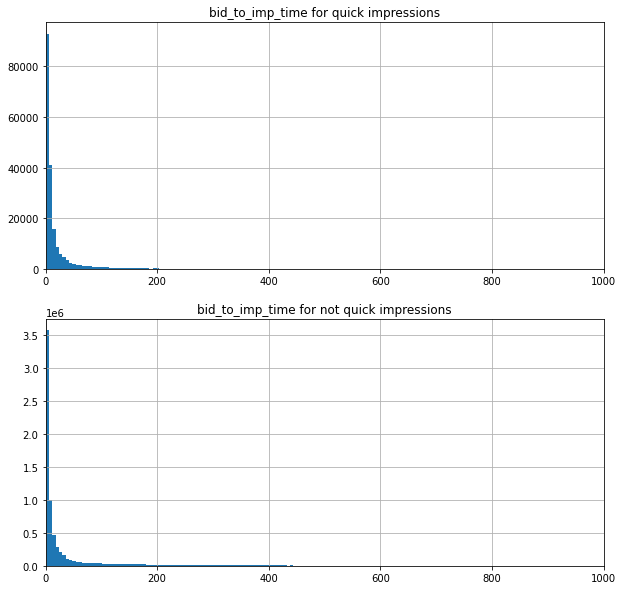

In [125]:
df['quick_imp'] = df.tid_campaign_ts.isin(quick_imps_list)
df['bid_to_imp_time'] = np.where(df.impressions > 0, (df['etimestamp'] - df['timestamp']).dt.total_seconds(), np.nan)
fig, ax = plt.subplots(2,1,figsize = (10,10))
df.loc[(df.quick_imp == True) & (df.bid_to_imp_time < 6000), 'bid_to_imp_time'].hist(bins = 1000, ax = ax[0])
ax[0].set_xlim(0,1000)
ax[0].set_title('bid_to_imp_time for quick impressions')
df.loc[~df.quick_imp & (df.bid_to_imp_time < 6000), 'bid_to_imp_time'].hist(bins = 1000, ax = ax[1])
ax[1].set_xlim(0,1000)
ax[1].set_title('bid_to_imp_time for not quick impressions')

Text(0.5, 1.0, 'Percent of Cost spent on impressions X seconds after the previous impression in a day')

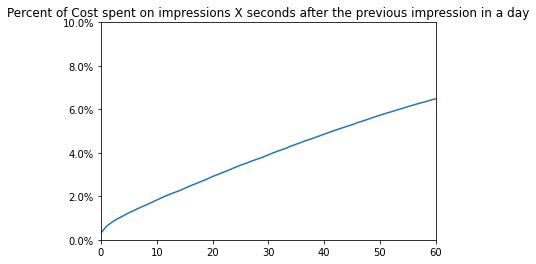

In [126]:
pivot = df.pivot_table(values = 'cost', index = 'time_since_last_imp', aggfunc = np.sum)
sov = 100*pivot.cumsum().div(df['cost'].sum())
plt.plot(sov)
plt.gca().set_xlim(0,60)
plt.gca().set_ylim(0,10)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(100))
plt.title('Percent of Cost spent on impressions X seconds after the previous impression in a day')

About 2% of cost is spent on impressions that come 10 seconds after the previous. 

In [127]:
pivot1 = df.groupby('ssb_campaign_uuid')['cost'].sum().to_frame()
pivot2 = df_campaigns_joined.groupby('ssb_campaign_uuid')['fcap_consecutive_impressions','fcap_min_impressions_interval'].mean()
pivot1.join(pivot2).reset_index().fillna(-1).pivot_table(values = ['cost','ssb_campaign_uuid'], index = ['fcap_consecutive_impressions','fcap_min_impressions_interval'], aggfunc = {'cost':np.sum, 'ssb_campaign_uuid':lambda x:len(x.unique())}, margins = True).fillna(0)

<ipython-input-127-1ff9b97951c8>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pivot2 = df_campaigns_joined.groupby('ssb_campaign_uuid')['fcap_consecutive_impressions','fcap_min_impressions_interval'].mean()


cost  \
fcap_consecutive_impressions fcap_min_impressions_interval                 
1.0                          600.0                              3.776613   
                             900.0                             44.709386   
                             1200.0                         25096.069158   
All                                                         25144.555157   

                                                            ssb_campaign_uuid  
fcap_consecutive_impressions fcap_min_impressions_interval                     
1.0                          600.0                                          1  
                             900.0                                          1  
                             1200.0                                       234  
All                                                                       236

all of the money making campaigns have consecutive impressions set at 1, and the interval of at least 10 minutes...

### where are these short impressions located?

In [128]:
pivot = (256/k)*df.groupby('quick_imp')['impressions','clicks','installs','spend','cost'].sum()
pivot.sort_values('cost', ascending = False, inplace = True)
pivot['ctr'] = 100*pivot.clicks/pivot.impressions
pivot['ir'] = 100*pivot.installs/pivot.clicks
pivot['cpm'] = 1000*pivot.cost/pivot.impressions
pivot['ipm'] = 1000*pivot.installs/pivot.impressions
pivot['profit'] = pivot.spend - pivot.cost
pivot['margin'] = 100*pivot.profit/pivot.spend
pivot[['impressions','clicks','ctr','installs','ir','ipm','cpm','spend','cost','profit','margin']].style.format(format_map)

<ipython-input-128-d01c4d1a2f49>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pivot = (256/k)*df.groupby('quick_imp')['impressions','clicks','installs','spend','cost'].sum()


In [129]:
quick_imp_hosting_bnds = df.loc[df.quick_imp, 'hosting_bnd'].unique().tolist()

In [130]:
pivot = (256/k)*(df.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = ['hosting_bnd','quick_imp'], aggfunc = np.sum))
pivot['ctr'] = 100*pivot.clicks/pivot.impressions
pivot['ir'] = 100*pivot.installs/pivot.clicks
pivot['cpm'] = 1000*pivot.cost/pivot.impressions
pivot['ipm'] = 1000*pivot.installs/pivot.impressions
pivot['profit'] = pivot.spend - pivot.cost
pivot['margin'] = 100*pivot.profit/pivot.spend
pivot['total_cost'] = pivot.groupby('hosting_bnd')['cost'].transform(sum)
pivot['cost_sov'] = 100*pivot['cost']/pivot['total_cost']
pivot.sort_values(['total_cost','quick_imp'], ascending = False, inplace = True)
cols = ['impressions','clicks','ctr','installs','ir','ipm','cpm','spend','cost','cost_sov','profit','margin', 'total_cost']

high_quick_imp_bnds = pivot[(pivot.index.get_level_values(1) == True) & (pivot.cost_sov > 10)].index.get_level_values(0).tolist()
filtered_pivot = pivot.loc[pivot.index.get_level_values(0).isin(high_quick_imp_bnds), cols]
filtered_pivot.head(30).style.format(format_map).background_gradient(cmap = cm, subset = ['ctr','ir','ipm','cpm','cost_sov','margin'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


In [131]:
pivot = (256/k)*df.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = ['exchange_name','quick_imp'], aggfunc = np.sum)
pivot['ctr'] = 100*pivot.clicks/pivot.impressions
pivot['ir'] = 100*pivot.installs/pivot.clicks
pivot['cpm'] = 1000*pivot.cost/pivot.impressions
pivot['ipm'] = 1000*pivot.installs/pivot.impressions
pivot['profit'] = pivot.spend - pivot.cost
pivot['margin'] = 100*pivot.profit/pivot.spend
pivot['total_cost'] = pivot.groupby('exchange_name')['cost'].transform(sum)
pivot['cost_sov'] = 100*pivot['cost']/pivot['total_cost']
pivot.sort_values(['total_cost','quick_imp'], ascending = False, inplace = True)
cols = ['impressions','clicks','ctr','installs','ir','ipm','cpm','spend','cost','cost_sov','profit','margin', 'total_cost']

pivot[cols].head(30).style.format(format_map).background_gradient(cmap = cm, subset = ['ctr','ir','ipm','cpm','cost_sov','margin'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


In [132]:
pivot = (256/k)*(df[df.hosting_bnd.isin(quick_imp_hosting_bnds)].pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = ['hosting_bnd','exchange_name','quick_imp'], aggfunc = np.sum))
pivot['ctr'] = 100*pivot.clicks/pivot.impressions
pivot['ir'] = 100*pivot.installs/pivot.clicks
pivot['cpm'] = 1000*pivot.cost/pivot.impressions
pivot['ipm'] = 1000*pivot.installs/pivot.impressions
pivot['profit'] = pivot.spend - pivot.cost
pivot['margin'] = 100*pivot.profit/pivot.spend
pivot['total_cost'] = pivot.groupby('hosting_bnd')['cost'].transform(sum)
pivot['bnd_exchange_cost'] = pivot.groupby(['hosting_bnd','exchange_name'])['cost'].transform(sum)
pivot['cost_sov'] = 100*pivot['cost']/pivot['total_cost']
pivot.sort_values(['total_cost','bnd_exchange_cost','quick_imp'], ascending = False, inplace = True)
cols = ['impressions','clicks','ctr','installs','ir','ipm','cpm','spend','cost','cost_sov','profit','margin', 'total_cost']

filtered_pivot = pivot.loc[(pivot.index.get_level_values(0).isin(high_quick_imp_bnds)), cols]
filtered_pivot.head(90).style.format(format_map).background_gradient(cmap = cm, subset = ['ctr','ir','ipm','cpm','cost_sov','margin'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


In [133]:
i = ['campaign_name']
pivot = (256/k)*(df.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = i + ['quick_imp'], aggfunc = np.sum))
pivot['ctr'] = 100*pivot.clicks/pivot.impressions
pivot['ir'] = 100*pivot.installs/pivot.clicks
pivot['cpm'] = 1000*pivot.cost/pivot.impressions
pivot['ipm'] = 1000*pivot.installs/pivot.impressions
pivot['profit'] = pivot.spend - pivot.cost
pivot['margin'] = 100*pivot.profit/pivot.spend
pivot['total_cost'] = pivot.groupby(i)['cost'].transform(sum)
pivot['cost_sov'] = 100*pivot['cost']/pivot['total_cost']
pivot.sort_values(['total_cost','quick_imp'], ascending = False, inplace = True)
cols = ['impressions','clicks','ctr','installs','ir','ipm','cpm','spend','cost','cost_sov','profit','margin', 'total_cost']

filtered_pivot = pivot.loc[:, cols]
filtered_pivot.head(90).style.format(format_map).background_gradient(cmap = cm, subset = ['ctr','ir','ipm','cpm','cost_sov','margin'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


In [136]:
i = ['country']
pivot = (256/k)*(df.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = i + ['quick_imp'], aggfunc = np.sum))
pivot['ctr'] = 100*pivot.clicks/pivot.impressions
pivot['ir'] = 100*pivot.installs/pivot.clicks
pivot['cpm'] = 1000*pivot.cost/pivot.impressions
pivot['ipm'] = 1000*pivot.installs/pivot.impressions
pivot['profit'] = pivot.spend - pivot.cost
pivot['margin'] = 100*pivot.profit/pivot.spend
pivot['total_cost'] = pivot.groupby(i)['cost'].transform(sum)
pivot['cost_sov'] = 100*pivot['cost']/pivot['total_cost']
pivot.sort_values(['total_cost','quick_imp'], ascending = False, inplace = True)
cols = ['impressions','clicks','ctr','installs','ir','ipm','cpm','spend','cost','cost_sov','profit','margin', 'total_cost']

filtered_pivot = pivot.loc[:, cols]
filtered_pivot.head(90).style.format(format_map).background_gradient(cmap = cm, subset = ['ctr','ir','ipm','cpm','cost_sov','margin'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


In [137]:
i = ['exchange_name']
pivot = (256/k)*(df.pivot_table(values = ['impressions','clicks','installs','spend','cost'], index = i + ['quick_imp'], aggfunc = np.sum))
pivot['ctr'] = 100*pivot.clicks/pivot.impressions
pivot['ir'] = 100*pivot.installs/pivot.clicks
pivot['cpm'] = 1000*pivot.cost/pivot.impressions
pivot['ipm'] = 1000*pivot.installs/pivot.impressions
pivot['profit'] = pivot.spend - pivot.cost
pivot['margin'] = 100*pivot.profit/pivot.spend
pivot['total_cost'] = pivot.groupby(i)['cost'].transform(sum)
pivot['cost_sov'] = 100*pivot['cost']/pivot['total_cost']
pivot.sort_values(['total_cost','quick_imp'], ascending = False, inplace = True)
cols = ['impressions','clicks','ctr','installs','ir','ipm','cpm','spend','cost','cost_sov','profit','margin', 'total_cost']

filtered_pivot = pivot.loc[:, cols]
filtered_pivot.head(90).style.format(format_map).background_gradient(cmap = cm, subset = ['ctr','ir','ipm','cpm','cost_sov','margin'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


# opportunity by campaign

In [138]:
hr_max = 3
i = 'campaign_name'

pivot = (256/k)*joined.loc[(joined.tti >= 0) & (joined.tti <= hr_max)].pivot_table(values = 'install_ts', index = i, aggfunc = 'nunique')
pivot2 = (256/k)*df.loc[(df.sponsored_bnd.isin(bundles_w_organics))].pivot_table(values = 'installs', index = i, aggfunc = np.sum)
pivot = pivot.join(pivot2)
pivot.columns = ['added_installs','installs']
pivot['opp_pct'] = 100*pivot.added_installs/pivot.installs
pivot.sort_values('installs', ascending = False, inplace = True)
pivot.head(30).style.format('{:,.0f}').format({'opp_pct':'{:,.0f}%'}).background_gradient(cmap=cm, subset = ['opp_pct'])

This is a measurement of just the installs that would have happened anyways. There will be some amount of users that will actually be persuaded to install due to our `X`th impression per day.

# checking bid frequency

In [4]:
df_bids = bigquery_client.query(f"""
select 
    t_created
    , date 
    , hour
    , tid
    , hosting_bnd
    , max(hosting_app_name) as hosting_app_name
    , exchange_id
    , event_type
    , id
    , ssb_campaign_uuid
    , campaign_name
    , sponsored_bnd
    , max(sponsored_app_name) as sponsored_app_name
    , bidfloor
    , dense_rank() over (partition by tid, ssb_campaign_uuid, date, event_type, hosting_bnd order by t_created) bid_number_day
from 
(
    select
        r.t_created
        , date(r.t_created) as date
        , extract(hour from r.t_created) as hour
        , r.tid
        , LOWER(JSON_EXTRACT(r.raw_request, '$.app.bundle')) as hosting_bnd
        , JSON_EXTRACT(r.raw_request, '$.app.name') as hosting_app_name
        , JSON_EXTRACT(r.raw_request, '$.imp[0].bidfloor') as bidfloor
        , r.exchange_id 
        , r.event_type
        , r.id
        , r.ssb_campaign_uuid 
        , c.name as campaign_name
        , sp.bundle as sponsored_bnd
        , sp.name as sponsored_app_name
    from stats.auctions_bids r
    left join metadata.campaigns c
        on r.ssb_campaign_uuid = c.uuid
    left join metadata.apps sp
        on r.sponsored_app_id = sp.app_id
    where
        date(t_created) >= '{start_dt}'
        and date(t_created) <= '{end_dt}'
        and right(r.tid,2) = '00'
    group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14
) t
group by 1,2,3,4,5,7,8,9,10,11,12,14
""").to_dataframe()
df_bids = pd.merge(df_bids, exchange, on = 'exchange_id', how = 'left')

In [5]:
df_bids['bidfloor'].fillna(-1).value_counts()

-1             15191772
0.02            7400306
0.09             635170
0.07             547926
0.01             421603
                 ...   
1.325742              1
0.215125632           1
4.795864              1
2.923999              1
0.4361                1
Name: bidfloor, Length: 164990, dtype: int64

In [6]:
df_bids.sort_values(['tid','hosting_bnd','event_type','date','t_created'], inplace = True)
df_bids['prev_auction_ts'] = df_bids[df_bids.event_type == 'auction'].groupby(['tid','hosting_bnd','date','event_type'])['t_created'].shift()
df_bids['prev_bid_ts'] = df_bids[df_bids.event_type == 'bid'].groupby(['tid','ssb_campaign_uuid','hosting_bnd','date','event_type'])['t_created'].shift()

df_bids['time_since_last_bid'] = np.where(df_bids.event_type == 'bid'
                                          , (df_bids.t_created - df_bids.prev_bid_ts).dt.total_seconds()
                                          , np.nan)
df_bids['time_since_last_auction'] = np.where(df_bids.event_type == 'auction'
                                          , (df_bids.t_created - df_bids.prev_auction_ts).dt.total_seconds()
                                          , np.nan)

In [7]:
df_bids['hour'] = df_bids.t_created.apply(lambda x:x.hour)
df_bids['minute'] = df_bids.t_created.apply(lambda x:x.minute)

In [8]:
df_bids['hosting_bnd'] = df_bids['hosting_bnd'].str[1:-1]
df_bids['hosting_app_name'] = df_bids['hosting_app_name'].str[1:-1]
df_bids.sort_values(['tid','hosting_bnd','t_created'], inplace = True)
df_bids[df_bids.event_type == 'bid'].iloc[3065:3095]

t_created        date  hour  \
39477812 2021-09-22 12:52:39.477960+00:00  2021-09-22    12   
14904433 2021-09-22 13:34:45.466492+00:00  2021-09-22    13   
17400479 2021-09-22 13:38:56.410267+00:00  2021-09-22    13   
31980203 2021-09-22 15:36:11.343138+00:00  2021-09-22    15   
26144172 2021-09-23 04:05:55.455024+00:00  2021-09-23     4   
22123527 2021-09-24 12:20:27.898000+00:00  2021-09-24    12   
34618333 2021-09-24 12:21:59.959501+00:00  2021-09-24    12   
18230746 2021-09-30 12:34:37.683987+00:00  2021-09-30    12   
7817317  2021-09-30 12:35:55.578764+00:00  2021-09-30    12   
2823668  2021-09-30 12:36:04.426611+00:00  2021-09-30    12   
7402982  2021-09-30 12:37:24.188864+00:00  2021-09-30    12   
33648129 2021-09-30 12:38:22.411826+00:00  2021-09-30    12   
22401310 2021-09-30 12:54:37.570799+00:00  2021-09-30    12   
32812152 2021-09-30 13:21:45.981551+00:00  2021-09-30    13   
21982757 2021-09-30 13:22:42.451893+00:00  2021-09-30    13   
2407603  2021-09-30 13:22:57.583336+00:00  2021-09-30    13   
19485185 2021-10-07 13:05:52.097199+00:00  2021-10-07    13   
5735394  2021-10-07 13:06:23.953013+00:00  2021-10-07    13   
17330912 2021-09-28 09:21:52.111244+00:00  2021-09-28     9   
37360701 2021-10-04 16:07:56.858479+00:00  2021-10-04    16   
30694966 2021-10-04 16:08:52.730189+00:00  2021-10-04    16   
11533491 2021-10-04 16:34:59.401402+00:00  2021-10-04    16   
4451915  2021-10-04 16:49:18.849227+00:00  2021-10-04    16   
40278102 2021-10-04 16:49:49.803379+00:00  2021-10-04    16   
19031316 2021-10-04 16:49:57.022766+00:00  2021-10-04    16   
20281508 2021-10-04 16:50:18.328803+00:00  2021-10-04    16   
11117162 2021-10-04 16:50:52.664721+00:00  2021-10-04    16   
27776844 2021-10-04 16:51:19.202736+00:00  2021-10-04    16   
4868193  2021-10-04 16:51:40.669208+00:00  2021-10-04    16   
17363817 2021-10-04 16:52:35.156428+00:00  2021-10-04    16   

                                       tid hosting_bnd  \
39477812  0000c91b937f61fe8c7440f7e618ea00   921765888   
14904433  0000c91b937f61fe8c7440f7e618ea00   921765888   
17400479  0000c91b937f61fe8c7440f7e618ea00   921765888   
31980203  0000c91b937f61fe8c7440f7e618ea00   921765888   
26144172  0000c91b937f61fe8c7440f7e618ea00   921765888   
22123527  0000c91b937f61fe8c7440f7e618ea00   921765888   
34618333  0000c91b937f61fe8c7440f7e618ea00   921765888   
18230746  0000c91b937f61fe8c7440f7e618ea00   921765888   
7817317   0000c91b937f61fe8c7440f7e618ea00   921765888   
2823668   0000c91b937f61fe8c7440f7e618ea00   921765888   
7402982   0000c91b937f61fe8c7440f7e618ea00   921765888   
33648129  0000c91b937f61fe8c7440f7e618ea00   921765888   
22401310  0000c91b937f61fe8c7440f7e618ea00   921765888   
32812152  0000c91b937f61fe8c7440f7e618ea00   921765888   
21982757  0000c91b937f61fe8c7440f7e618ea00   921765888   
2407603   0000c91b937f61fe8c7440f7e618ea00   921765888   
19485185  0000c91b937f61fe8c7440f7e618ea00   921765888   
5735394   0000c91b937f61fe8c7440f7e618ea00   921765888   
17330912  0000c9562eafb8aa63dcef5a6250b900        None   
37360701  0000cc5bf57c07eabd1113abaacaf000  1463509237   
30694966  0000cc5bf57c07eabd1113abaacaf000  1463509237   
11533491  0000cc5bf57c07eabd1113abaacaf000  1463509237   
4451915   0000cc5bf57c07eabd1113abaacaf000  1463509237   
40278102  0000cc5bf57c07eabd1113abaacaf000  1463509237   
19031316  0000cc5bf57c07eabd1113abaacaf000  1463509237   
20281508  0000cc5bf57c07eabd1113abaacaf000  1463509237   
11117162  0000cc5bf57c07eabd1113abaacaf000  1463509237   
27776844  0000cc5bf57c07eabd1113abaacaf000  1463509237   
4868193   0000cc5bf57c07eabd1113abaacaf000  1463509237   
17363817  0000cc5bf57c07eabd1113abaacaf000  1463509237   

                        hosting_app_name  exchange_id event_type  \
39477812  Audiomack - Download New Music           44        bid   
14904433  Audiomack - Download New Music           44        bid   
17400479  Audiomack - Download New Music           44        bid   
3198020

So many bids on the same user, same campaign.. 

In [9]:
pivot = df_bids.pivot_table(values = 'id', index = ['hosting_bnd','date','hour','minute','tid'], columns = 'event_type', aggfunc = lambda x:len(x.unique()))
auction_pivot = pivot.reset_index().groupby('auction')['tid'].count()
bid_pivot = pivot.reset_index().groupby('bid')['tid'].count()
auction_sov_pivot = 100*auction_pivot.cumsum()/auction_pivot.sum()
bid_sov_pivot = 100*bid_pivot.cumsum()/bid_pivot.sum()

In [10]:
auction_sov_pivot

auction
1.0       44.737852
2.0       61.439517
3.0       69.895278
4.0       75.104085
5.0       78.756737
            ...    
722.0     99.999862
725.0     99.999897
737.0     99.999931
743.0     99.999966
748.0    100.000000
Name: tid, Length: 570, dtype: float64

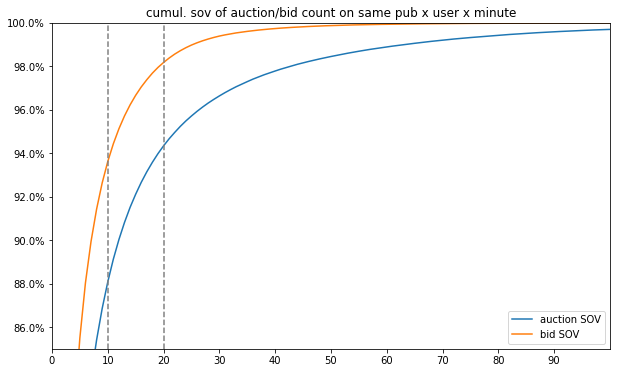

In [11]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(auction_sov_pivot)
ax.plot(bid_sov_pivot)
ax.legend(['auction SOV','bid SOV'])
ax.set_xlim(0,100)
ax.set_xticks(range(0,100,10))
ax.set_ylim(85,100)
ax.axvline(x = 10, ls = '--', color = 'grey')
ax.axvline(x = 20, ls = '--', color = 'grey')
ax.set_title('cumul. sov of auction/bid count on same pub x user x minute')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))

~6% of the time, we are getting >20 auctions on the same user from the same pub in the same minute.  
~2% of the time, we are bidding >20 times on the same user on the same pub in the same minute.  
Given this, it is unsurprising that ~7% of our cost is spent on impressions <60 seconds after the previous impression on the same user.

Text(0.5, 1.0, 'time since last bid')

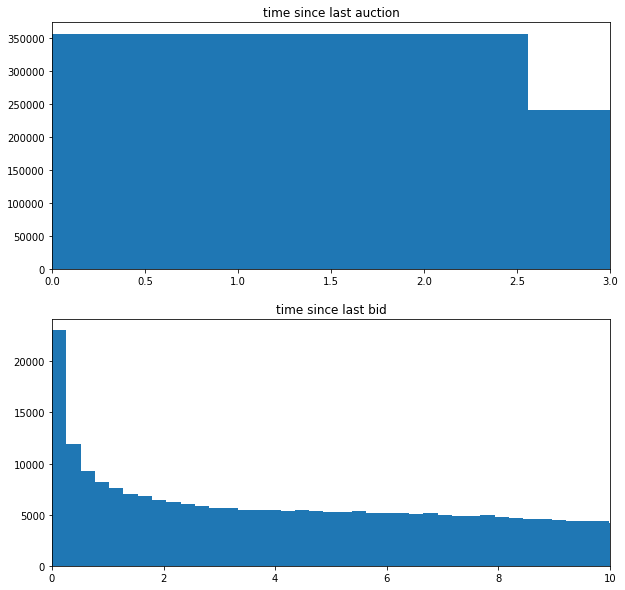

In [12]:
fig, ax = plt.subplots(2,1,figsize = (10,10))
ax[0].hist(256*df_bids.loc[df_bids.time_since_last_auction < 10, 'time_since_last_auction'], bins = 1000)
ax[0].set_xlim(0,3)
ax[0].set_title('time since last auction')
ax[1].hist(256*df_bids.loc[df_bids.time_since_last_bid < 10, 'time_since_last_bid'], bins = 10000)
ax[1].set_xlim(0,10)
ax[1].set_title('time since last bid')

We are actually bidding on a user milliseconds after the previous bid:

In [13]:
df_bids[(df_bids['time_since_last_bid'] > 0) & (df_bids['time_since_last_bid'] < 0.01)]

t_created        date  hour  \
7991986  2021-09-28 16:07:57.091367+00:00  2021-09-28    16   
5338650  2021-09-22 21:04:48.027148+00:00  2021-09-22    21   
19094826 2021-09-22 20:49:50.638343+00:00  2021-09-22    20   
21619576 2021-09-22 00:07:20.664786+00:00  2021-09-22     0   
22450199 2021-09-22 22:21:00.199424+00:00  2021-09-22    22   
...                                   ...         ...   ...   
13335184 2021-09-24 11:36:33.935808+00:00  2021-09-24    11   
422768   2021-09-24 11:50:33.300584+00:00  2021-09-24    11   
17436884 2021-09-26 19:04:19.930622+00:00  2021-09-26    19   
26597975 2021-09-27 15:04:57.762819+00:00  2021-09-27    15   
13637560 2021-09-23 21:35:28.990291+00:00  2021-09-23    21   

                                       tid                       hosting_bnd  \
7991986   0000a84a1851193de4fa5ef56171b100                com.picsart.studio   
5338650   0000d8d01e88c6dfac5fe66cd8110700          com.blueflamingo.herolab   
19094826  0000d8d01e88c6dfac5fe66cd8110700               com.charityrun.game   
21619576  0000d8d01e88c6dfac5fe66cd8110700            com.fidgettrading.game   
22450199  0000d8d01e88c6dfac5fe66cd8110700          com.fidgettrading3d.game   
...                                    ...                               ...   
13335184  ffe0e8ef25350642b8dde9950fbe5400  com.easybrain.block.puzzle.games   
422768    ffe0e8ef25350642b8dde9950fbe5400  com.easybrain.block.puzzle.games   
17436884  ffe0e8ef25350642b8dde9950fbe5400  com.easybrain.block.puzzle.games   
26597975  ffe0e8ef25350642b8dde9950fbe5400  com.easybrain.block.puzzle.games   
13637560  ffe0e8ef25350642b8dde9950fbe5400           in.playsimple.tripcross   

                                          hosting_app_name  exchange_id  \
7991986                       PicsArt Photo Studio Android            3   
5338650                                        Heroes Inc!           39   
19094826                                       Destiny Run           39   
21619576  Fidget Toys Trading: Pop It Games & Fidget Trade           37   
22450199                   Fidget Trading 3D - Fidget Toys           37   
...                                                    ...          ...   
13335184                                     Blockudoku GP            3   
422768                                       Blockudoku GP            3   
17436884                                     Blockudoku GP            3   
26597975                                     Blockudoku GP            3   
13637560                                     Crossword Jam           38   

         event_type                                                 id  \
7991986         bid  0000a84a1851193de4fa5ef56171b10061bcf067baae9a...   
5338650         bid  0000d8d01e88c6dfac5fe66cd8110700502650b440afe3...   
19094826        bid  0000d8d01e88c6dfac5fe66cd81107005448e76d1bef84...   
21619576        bid  0000d8d01e88c6dfac5fe66cd8110700737900b4c24b8e...   
22450199        bid  0000d8d01e88c6dfac5fe66cd8110700628d209167d975...   
...             ...                                                ...   
13335184        bid  ffe0e8ef25350642b8dde9950fbe540029803947435a9e...   
422768          bid  ffe0e8ef25350642b8dde9950fbe54000e6a1b32ba401c...   
17436884        bid  ffe0e8ef25350642b8dde9950fbe54000c26418bd9e41c...   
26597975        bid  ffe0e8ef25350642b8dde9950fbe54001255ce75ef5a37...   
13637560        bid  ffe0e8ef25350642b8dde9950fbe54002ed6430599579b...   

                         ssb_campaign_uuid  ...               sponsored_bnd  \
7991986   9adb91f88b6b2579425c8e10415c31b5  ...                        None   
5338650   16d935fca4ea8b4dffa296ba147ec7df  ...  com.particlenews.newsbreak   
19094826  16d935fca4ea8b4dffa296ba147ec7df  ...  com.particlenews.newsbreak   
21619576  97ab42120540d6b4520f7752a2869963  ...                sg.bigo.live   
22450199  97ab42120540d6b4520f7752a2869963  ...                sg.bigo.live   
...                                    ...  ...   

In [14]:
df_bids[(df_bids.tid == '0000d8d01e88c6dfac5fe66cd8110700') & (df_bids.hosting_bnd == 'com.blueflamingo.herolab')]

t_created        date  hour  \
18066510 2021-09-22 21:03:34.694037+00:00  2021-09-22    21   
5549910  2021-09-22 21:03:45.427144+00:00  2021-09-22    21   
4718999  2021-09-22 21:03:59.854980+00:00  2021-09-22    21   
14975611 2021-09-22 21:04:00.499132+00:00  2021-09-22    21   
11402087 2021-09-22 21:04:03.295290+00:00  2021-09-22    21   
...                                   ...         ...   ...   
6623385  2021-09-22 21:09:26.028838+00:00  2021-09-22    21   
18288111 2021-09-22 21:09:29.238809+00:00  2021-09-22    21   
19742276 2021-09-22 21:09:30.492784+00:00  2021-09-22    21   
14505511 2021-09-22 21:09:37.008633+00:00  2021-09-22    21   
5755460  2021-09-22 21:09:44.133890+00:00  2021-09-22    21   

                                       tid               hosting_bnd  \
18066510  0000d8d01e88c6dfac5fe66cd8110700  com.blueflamingo.herolab   
5549910   0000d8d01e88c6dfac5fe66cd8110700  com.blueflamingo.herolab   
4718999   0000d8d01e88c6dfac5fe66cd8110700  com.blueflamingo.herolab   
14975611  0000d8d01e88c6dfac5fe66cd8110700  com.blueflamingo.herolab   
11402087  0000d8d01e88c6dfac5fe66cd8110700  com.blueflamingo.herolab   
...                                    ...                       ...   
6623385   0000d8d01e88c6dfac5fe66cd8110700  com.blueflamingo.herolab   
18288111  0000d8d01e88c6dfac5fe66cd8110700  com.blueflamingo.herolab   
19742276  0000d8d01e88c6dfac5fe66cd8110700  com.blueflamingo.herolab   
14505511  0000d8d01e88c6dfac5fe66cd8110700  com.blueflamingo.herolab   
5755460   0000d8d01e88c6dfac5fe66cd8110700  com.blueflamingo.herolab   

         hosting_app_name  exchange_id event_type  \
18066510      Heroes Inc!            1    auction   
5549910       Heroes Inc!            1    auction   
4718999       Heroes Inc!            1    auction   
14975611      Heroes Inc!           44        bid   
11402087      Heroes Inc!            1    auction   
...                   ...          ...        ...   
6623385       Heroes Inc!           39        bid   
18288111      Heroes Inc!           39        bid   
19742276      Heroes Inc!            1    auction   
14505511      Heroes Inc!           39        bid   
5755460       Heroes Inc!           39        bid   

                                                         id  \
18066510  0000d8d01e88c6dfac5fe66cd811070064fbfc527b8b5d...   
5549910   0000d8d01e88c6dfac5fe66cd811070052a63455ae22cf...   
4718999   0000d8d01e88c6dfac5fe66cd811070073f810691cb1e9...   
14975611  0000d8d01e88c6dfac5fe66cd811070065ac8f7ae3b2c7...   
11402087  0000d8d01e88c6dfac5fe66cd811070051adfba7b68882...   
...                                                     ...   
6623385   0000d8d01e88c6dfac5fe66cd811070044c7b567f807cd...   
18288111  0000d8d01e88c6dfac5fe66cd8110700716bf9cbb6ae57...   
19742276  0000d8d01e88c6dfac5fe66cd8110700461182c6c52474...   
14505511  0000d8d01e88c6dfac5fe66cd811070041660b84139049...   
5755460   0000d8d01e88c6dfac5fe66cd81107007bef3853ff5b62...   

                         ssb_campaign_uuid  ...               sponsored_bnd  \
18066510                              None  ...                        None   
5549910                               None  ...                        None   
4718999                               None  ...                        None   
14975611  f26adcfdd8b0a653e86528af46961c1d  ...      com.home.weather.radar   
11402087                              None  ...                        None   
...                                    ...  ...                         ...   
6623385   97ab42120540d6b4520f7752a2869963  ...                sg.bigo.live   
18288111  97ab42120540d6b4520f7752a2869963  ...                sg.bigo.live   
19742276                              None  ...                        None   
14505511  16d935fca4ea8b4dffa296ba147ec7df  ...  com.particlenews.newsbreak   
5755460   16d935fca4ea8b4dffa296ba147ec7df  ...  com.particlenews.newsbreak   

                                 sponsored_app_name bidfloor bid_nu

In [15]:
df_bids['quick_auction'] = (df_bids.time_since_last_auction > 0) & (df_bids.time_since_last_auction < 1)
df_bids['quick_bid'] = (df_bids.time_since_last_bid > 0) & (df_bids.time_since_last_bid < 1)

In [16]:
df_bids[(df_bids.tid == '000000df0b395776e494effa2c936700') & (df_bids.hosting_bnd == 'com.basketball.diamond.hoop')].head(30)

t_created        date  hour  \
9673176  2021-09-16 18:34:08.915523+00:00  2021-09-16    18   
37168802 2021-09-16 18:34:24.809703+00:00  2021-09-16    18   
2195788  2021-09-16 18:34:30.015397+00:00  2021-09-16    18   
39236189 2021-09-16 18:34:34.739363+00:00  2021-09-16    18   
25511237 2021-09-16 18:34:43.208952+00:00  2021-09-16    18   
1769296  2021-09-16 18:35:01.077087+00:00  2021-09-16    18   
31334799 2021-09-16 18:35:17.746383+00:00  2021-09-16    18   
33832068 2021-09-16 18:35:29.183039+00:00  2021-09-16    18   
38415587 2021-09-16 18:35:29.796547+00:00  2021-09-16    18   
37995745 2021-09-16 18:35:32.511646+00:00  2021-09-16    18   
30917757 2021-09-16 18:35:49.629241+00:00  2021-09-16    18   
29685261 2021-09-16 18:35:51.816967+00:00  2021-09-16    18   
10079046 2021-09-16 18:35:53.432511+00:00  2021-09-16    18   
25932668 2021-09-16 18:35:56.908354+00:00  2021-09-16    18   
15910033 2021-09-16 18:36:00.707997+00:00  2021-09-16    18   
25932669 2021-09-16 18:36:01.669740+00:00  2021-09-16    18   
5532035  2021-09-16 18:36:20.448348+00:00  2021-09-16    18   
15494919 2021-09-16 18:36:31.911503+00:00  2021-09-16    18   
3845596  2021-09-16 18:36:38.725439+00:00  2021-09-16    18   
37569695 2021-09-16 18:36:40.071472+00:00  2021-09-16    18   
526545   2021-09-16 18:36:57.363573+00:00  2021-09-16    18   
8420278  2021-09-16 18:36:57.499581+00:00  2021-09-16    18   
16753212 2021-09-16 18:36:59.050479+00:00  2021-09-16    18   
5925182  2021-09-16 18:37:07.185839+00:00  2021-09-16    18   
2594655  2021-09-16 18:37:14.288427+00:00  2021-09-16    18   
2180452  2021-09-16 18:37:25.868274+00:00  2021-09-16    18   
21739270 2021-09-16 18:37:31.586953+00:00  2021-09-16    18   
519409   2021-09-16 18:37:39.288406+00:00  2021-09-16    18   
38820149 2021-09-16 18:38:00.273048+00:00  2021-09-16    18   
1767470  2021-09-16 18:38:17.771813+00:00  2021-09-16    18   

                                       tid                  hosting_bnd  \
9673176   000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
37168802  000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
2195788   000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
39236189  000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
25511237  000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
1769296   000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
31334799  000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
33832068  000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
38415587  000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
37995745  000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
30917757  000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
29685261  000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
10079046  000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
25932668  000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
15910033  000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
25932669  000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
5532035   000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
15494919  000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
3845596   000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
37569695  000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
526545    000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
8420278   000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
16753212  000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
5925182   000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
2594655   000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
2180452   000000df0b395776e494effa2c936700  com.basketball.diamond.hoop   
21739270  000000df0b395776e494effa2c936700  com.baske

<AxesSubplot:>

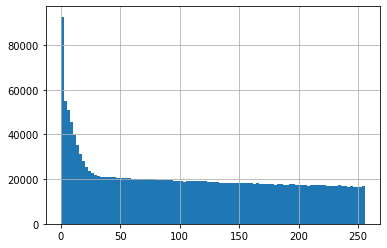

In [17]:
(256*df_bids.loc[df_bids.quick_bid == True, 'time_since_last_bid']).hist(bins = 100)

In [18]:
# quick auctions by exchange (fyber is not on advance bidding)
# different bid floors for subsequent auctions

In [32]:
pivot = 256*df_bids.pivot_table(values = 'id', index = 'exchange_name', columns = 'quick_auction', aggfunc = lambda x:len(x.unique()), margins = True)
pivot = pivot.fillna(0)
pivot['quick_rate'] = 100*pivot[True]/pivot['All']
pivot.sort_values('All', ascending = False, inplace = True)
styled_pivot = pivot.style.format('{:,.0f}').format({'quick_rate':'{:,.0f}%'}).background_gradient(cmap=cm, subset = 'quick_rate')
dfi.export(styled_pivot,f'export_tables/quick_auctions_byexchange_{start_dt}_{end_dt}.png')
styled_pivot

Fyber is not on advance bidding, but we are still seeing a high percent of quick auctions... 

In [29]:
pivot = 256*df_bids[df_bids.event_type == 'auction'].pivot_table(values = 'id', index = 'hosting_bnd', columns = 'quick_auction', aggfunc = lambda x:len(x.unique()), margins = True)
pivot = pivot.fillna(0)
pivot['quick_rate'] = 100*pivot[True]/pivot['All']
pivot.sort_values('All', ascending = False, inplace = True)
styled_pivot = pivot.head(40).style.format('{:,.0f}').format({'quick_rate':'{:,.0f}%'}).background_gradient(cmap=cm, subset = 'quick_rate')
dfi.export(styled_pivot, f'export_tables/quick_auctions_bypub_{start_dt}_{end_dt}.png')
styled_pivot

Ask Yoni for mediation platform - is quick auctions related to mediation platform? 

In [24]:
pivot = (256/k)*(df.pivot_table(values = ['impressions','cost'], index = ['hosting_bnd','quick_imp'], aggfunc = np.sum))
pivot['cost_sov'] = 100*pivot.cost / pivot.groupby('hosting_bnd')['cost'].transform(sum)
pivot['total_cost'] = pivot.groupby('hosting_bnd')['cost'].transform(sum)
pivot.sort_values('total_cost', ascending = False, inplace = True)
pivot.head(30).style.format('{:,.0f}').format({'cost_sov':'{:,.0f}%'})

NameError: name 'df' is not defined

In [27]:
pivot = 256*df_bids[df_bids.event_type == 'auction'].pivot_table(values = 'id', index = ['exchange_name','hosting_bnd'], columns = 'quick_auction', aggfunc = lambda x:len(x.unique()), margins = True)
pivot = pivot.fillna(0)
pivot['quick_rate'] = 100*pivot[True]/pivot['All']
pivot.sort_values('All', ascending = False, inplace = True)
styled_pivot = pivot.head(50).style.format('{:,.0f}').format({'quick_rate':'{:,.0f}%'}).background_gradient(cmap=cm, subset = 'quick_rate')
dfi.export(styled_pivot, f'export_tables/quick_auctions_bypub_{start_dt}_{end_dt}.png')
styled_pivot

There  a much larger discrepancy on the pub and exchange x pub level.

### are there different floors for subsequent auctions?


In [25]:
df_bids['tid_campaign'] = df_bids.apply(lambda x:str(x.tid)+'_'+str(x.ssb_campaign_uuid), axis = 1)
quick_tid_campaign = df_bids.loc[df_bids.quick_auction == True, 'tid_campaign'].unique().tolist()
df_bids.sort_values(['tid','hosting_bnd','ssb_campaign_uuid','t_created'], inplace = True)

cols = ['t_created','tid','id','bidfloor','hosting_bnd','ssb_campaign_uuid','exchange_id','event_type']
df_bids.loc[df_bids.tid_campaign.isin(quick_tid_campaign), cols].tail(30)

t_created                               tid  \
40974935 2021-09-10 00:04:45.031469+00:00  fe00fbcb7bfd2650584574eec32f6900   
25145421 2021-09-10 00:04:45.069720+00:00  fe00fbcb7bfd2650584574eec32f6900   
15563465 2021-09-10 00:05:24.807170+00:00  fe00fbcb7bfd2650584574eec32f6900   
34304310 2021-09-10 00:06:20.382837+00:00  fe00fbcb7bfd2650584574eec32f6900   
26432234 2021-09-10 00:06:48.273336+00:00  fe00fbcb7bfd2650584574eec32f6900   
27622969 2021-09-10 00:07:13.524412+00:00  fe00fbcb7bfd2650584574eec32f6900   
35990988 2021-09-10 00:07:43.622101+00:00  fe00fbcb7bfd2650584574eec32f6900   
10167248 2021-09-10 00:07:45.417108+00:00  fe00fbcb7bfd2650584574eec32f6900   
28439097 2021-09-26 01:09:25.076963+00:00  fe00fbcb7bfd2650584574eec32f6900   
13927223 2021-10-01 20:35:41.798532+00:00  fe00fbcb7bfd2650584574eec32f6900   
5215267  2021-10-01 20:35:51.230978+00:00  fe00fbcb7bfd2650584574eec32f6900   
8929235  2021-10-01 20:38:12.840563+00:00  fe00fbcb7bfd2650584574eec32f6900   
18927168 2021-10-01 20:49:17.482998+00:00  fe00fbcb7bfd2650584574eec32f6900   
17678487 2021-10-01 20:49:42.723626+00:00  fe00fbcb7bfd2650584574eec32f6900   
36439329 2021-10-01 20:50:50.748333+00:00  fe00fbcb7bfd2650584574eec32f6900   
25591837 2021-10-01 20:52:23.976825+00:00  fe00fbcb7bfd2650584574eec32f6900   
2298606  2021-09-21 16:20:02.361676+00:00  fe00fbcb7bfd2650584574eec32f6900   
31820038 2021-09-23 20:23:28.412631+00:00  fe00fbcb7bfd2650584574eec32f6900   
19738167 2021-09-23 20:36:36.700881+00:00  fe00fbcb7bfd2650584574eec32f6900   
27252421 2021-09-26 10:48:48.838250+00:00  fe00fbcb7bfd2650584574eec32f6900   
14764046 2021-09-26 11:04:52.893105+00:00  fe00fbcb7bfd2650584574eec32f6900   
15053847 2021-09-27 04:06:08.296476+00:00  fe00fbcb7bfd2650584574eec32f6900   
20059122 2021-09-27 04:06:30.279061+00:00  fe00fbcb7bfd2650584574eec32f6900   
35465780 2021-09-27 04:06:36.770821+00:00  fe00fbcb7bfd2650584574eec32f6900   
21310445 2021-09-27 04:06:45.306206+00:00  fe00fbcb7bfd2650584574eec32f6900   
15059911 2021-09-27 04:07:04.174606+00:00  fe00fbcb7bfd2650584574eec32f6900   
37966897 2021-09-27 04:19:43.943317+00:00  fe00fbcb7bfd2650584574eec32f6900   
3460038  2021-10-06 22:35:42.040712+00:00  fe00fbcb7bfd2650584574eec32f6900   
24721361 2021-10-06 22:52:39.982448+00:00  fe00fbcb7bfd2650584574eec32f6900   
36431334 2021-10-07 21:36:31.809124+00:00  fe00fbcb7bfd2650584574eec32f6900   

                                                         id bidfloor  \
40974935  fe00fbcb7bfd2650584574eec32f69006e5e8d6383b0ff...     None   
25145421  fe00fbcb7bfd2650584574eec32f69005959ccd1dfb005...     None   
15563465  fe00fbcb7bfd2650584574eec32f69006bb526c5ceb436...     None   
34304310  fe00fbcb7bfd2650584574eec32f6900452ddc94dbfc35...     None   
26432234  fe00fbcb7bfd2650584574eec32f69005322f56bc32ffe...     None   
27622969  fe00fbcb7bfd2650584574eec32f69004b564b044b4403...     None   
35990988  fe00fbcb7bfd2650584574eec32f69006f9745d63552bc...     None   
10167248  fe00fbcb7bfd2650584574eec32f69005f17caba48702e...    0.025   
28439097  fe00fbcb7bfd2650584574eec32f69004ca58df9fd4b14...     None   
13927223  fe00fbcb7bfd2650584574eec32f6900673dfa62eaacac...    0.025   
5215267   fe00fbcb7bfd2650584574eec32f69006526cc13f5a2fc...    0.025   
8929235   fe00fbcb7bfd2650584574eec32f69006f699828177f70...    0.025   
18927168  fe00fbcb7bfd2650584574eec32f69007ec3fa1bfc87aa...    0.025   
17678487  fe00fbcb7bfd2650584574eec32f69007d4d8620e8261b...    0.025   
36439329  fe00fbcb7bfd2650584574eec32f690075bbdb6450c6a2...    0.025   
25591837  fe00fbcb7bfd2650584574eec32f6900669f5d4112ce85...    0.025   
2298606   fe00fbcb7bfd2650584574eec32f69006d3d380cc3a205...     None   
31820038  fe00fbcb7bfd2650584574eec32f6900610ff9465a5c5a...     None   
19738167  fe00fbcb7bfd2650584574eec32f6900685ddddc61602e...     None   
27252421  fe00fbcb7bfd2650584574eec32f69004017866b44bbed...     None   
14764046  fe00fbcb7bfd2650584574eec32f690074d3f2fd695e6f...     None  

sometimes yes, sometimes no.